# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.429293212832776 -2.828289788690663
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #targetQs = tf.reshape(targetQs, shape=[-1, 1])
    #Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.3277 dloss:1.5958 dlossR:0.9371 dlossQ:0.6587
Episode:1 meanR:9.5000 rate:0.0180 gloss:0.2452 dloss:1.5496 dlossR:0.8780 dlossQ:0.6716
Episode:2 meanR:9.6667 rate:0.0200 gloss:0.1860 dloss:1.5193 dlossR:0.8417 dlossQ:0.6775
Episode:3 meanR:9.5000 rate:0.0180 gloss:0.1166 dloss:1.4718 dlossR:0.7858 dlossQ:0.6860
Episode:4 meanR:9.4000 rate:0.0180 gloss:0.0673 dloss:1.4383 dlossR:0.7483 dlossQ:0.6900
Episode:5 meanR:9.3333 rate:0.0180 gloss:0.0220 dloss:1.4032 dlossR:0.7109 dlossQ:0.6923
Episode:6 meanR:9.4286 rate:0.0200 gloss:-0.0123 dloss:1.3742 dlossR:0.6813 dlossQ:0.6929
Episode:7 meanR:9.2500 rate:0.0160 gloss:-0.0750 dloss:1.3184 dlossR:0.6278 dlossQ:0.6906
Episode:8 meanR:9.2222 rate:0.0180 gloss:-0.1066 dloss:1.2834 dlossR:0.5965 dlossQ:0.6869
Episode:9 meanR:9.2000 rate:0.0180 gloss:-0.1446 dloss:1.2426 dlossR:0.5620 dlossQ:0.6806
Episode:10 meanR:9.1818 rate:0.0180 gloss:-0.1889 dloss:1.2024 dlossR:0.5301 dlossQ:0.6724
Episode:11 mea

Episode:92 meanR:21.0323 rate:0.1360 gloss:-1.9297 dloss:0.6808 dlossR:0.4471 dlossQ:0.2337
Episode:93 meanR:21.3830 rate:0.1080 gloss:-1.6951 dloss:0.6231 dlossR:0.3481 dlossQ:0.2751
Episode:94 meanR:21.6211 rate:0.0880 gloss:-1.6789 dloss:0.5755 dlossR:0.2985 dlossQ:0.2770
Episode:95 meanR:21.7604 rate:0.0700 gloss:-1.6793 dloss:0.5314 dlossR:0.2543 dlossQ:0.2771
Episode:96 meanR:21.8247 rate:0.0560 gloss:-1.6603 dloss:0.5022 dlossR:0.2206 dlossQ:0.2816
Episode:97 meanR:21.8571 rate:0.0500 gloss:-1.6405 dloss:0.4937 dlossR:0.2069 dlossQ:0.2868
Episode:98 meanR:21.8283 rate:0.0380 gloss:-1.6263 dloss:0.4699 dlossR:0.1791 dlossQ:0.2908
Episode:99 meanR:21.8000 rate:0.0380 gloss:-1.6551 dloss:0.4609 dlossR:0.1774 dlossQ:0.2835
Episode:100 meanR:21.9000 rate:0.0400 gloss:-1.6729 dloss:0.4609 dlossR:0.1814 dlossQ:0.2795
Episode:101 meanR:21.9700 rate:0.0320 gloss:-1.6927 dloss:0.4349 dlossR:0.1606 dlossQ:0.2743
Episode:102 meanR:22.0200 rate:0.0300 gloss:-1.7369 dloss:0.4170 dlossR:0.1531

Episode:183 meanR:32.8300 rate:0.0260 gloss:-1.8751 dloss:0.3759 dlossR:0.1383 dlossQ:0.2376
Episode:184 meanR:32.4200 rate:0.0280 gloss:-1.8597 dloss:0.3857 dlossR:0.1444 dlossQ:0.2413
Episode:185 meanR:32.3100 rate:0.0240 gloss:-1.9557 dloss:0.3516 dlossR:0.1302 dlossQ:0.2214
Episode:186 meanR:32.1300 rate:0.0260 gloss:-1.9180 dloss:0.3651 dlossR:0.1366 dlossQ:0.2285
Episode:187 meanR:32.4600 rate:0.1640 gloss:-1.7115 dloss:0.7653 dlossR:0.4884 dlossQ:0.2768
Episode:188 meanR:32.2500 rate:0.2400 gloss:-1.7026 dloss:0.9535 dlossR:0.6746 dlossQ:0.2790
Episode:189 meanR:32.9600 rate:0.2980 gloss:-1.6447 dloss:1.0939 dlossR:0.7995 dlossQ:0.2944
Episode:190 meanR:33.7300 rate:0.2540 gloss:-1.8118 dloss:0.9951 dlossR:0.7395 dlossQ:0.2556
Episode:191 meanR:34.2500 rate:0.2220 gloss:-1.8789 dloss:0.9181 dlossR:0.6734 dlossQ:0.2447
Episode:192 meanR:34.5900 rate:0.2040 gloss:-1.8824 dloss:0.8675 dlossR:0.6248 dlossQ:0.2427
Episode:193 meanR:34.1400 rate:0.0180 gloss:-1.9329 dloss:0.3490 dloss

Episode:278 meanR:60.6100 rate:0.0280 gloss:-1.7240 dloss:0.4246 dlossR:0.1516 dlossQ:0.2730
Episode:279 meanR:60.3800 rate:0.0260 gloss:-1.8301 dloss:0.3878 dlossR:0.1403 dlossQ:0.2474
Episode:280 meanR:60.2300 rate:0.0220 gloss:-1.9259 dloss:0.3536 dlossR:0.1266 dlossQ:0.2269
Episode:281 meanR:59.9100 rate:0.0220 gloss:-1.9310 dloss:0.3525 dlossR:0.1265 dlossQ:0.2260
Episode:282 meanR:59.6700 rate:0.0240 gloss:-1.9699 dloss:0.3472 dlossR:0.1296 dlossQ:0.2176
Episode:283 meanR:59.8900 rate:0.0700 gloss:-1.6899 dloss:0.5536 dlossR:0.2625 dlossQ:0.2911
Episode:284 meanR:59.8500 rate:0.0200 gloss:-2.0562 dloss:0.3358 dlossR:0.1232 dlossQ:0.2126
Episode:285 meanR:59.8300 rate:0.0200 gloss:-1.8553 dloss:0.3705 dlossR:0.1264 dlossQ:0.2441
Episode:286 meanR:60.1600 rate:0.0920 gloss:-1.5641 dloss:0.6237 dlossR:0.3085 dlossQ:0.3152
Episode:287 meanR:60.0300 rate:0.1380 gloss:-1.5788 dloss:0.7256 dlossR:0.4137 dlossQ:0.3118
Episode:288 meanR:58.9600 rate:0.0260 gloss:-1.8936 dloss:0.3769 dloss

Episode:367 meanR:43.8700 rate:0.0980 gloss:-1.7140 dloss:0.5977 dlossR:0.3239 dlossQ:0.2737
Episode:368 meanR:39.5800 rate:0.0860 gloss:-1.7079 dloss:0.5693 dlossR:0.2941 dlossQ:0.2752
Episode:369 meanR:38.9900 rate:0.0520 gloss:-1.7444 dloss:0.4758 dlossR:0.2093 dlossQ:0.2666
Episode:370 meanR:38.4200 rate:0.0540 gloss:-1.7382 dloss:0.4826 dlossR:0.2145 dlossQ:0.2681
Episode:371 meanR:37.8500 rate:0.0540 gloss:-1.7563 dloss:0.4776 dlossR:0.2139 dlossQ:0.2636
Episode:372 meanR:37.5800 rate:0.0700 gloss:-1.7375 dloss:0.5228 dlossR:0.2546 dlossQ:0.2682
Episode:373 meanR:37.1800 rate:0.0440 gloss:-1.7817 dloss:0.4457 dlossR:0.1879 dlossQ:0.2578
Episode:374 meanR:37.0900 rate:0.0460 gloss:-1.8182 dloss:0.4420 dlossR:0.1922 dlossQ:0.2498
Episode:375 meanR:37.0500 rate:0.0420 gloss:-1.8480 dloss:0.4258 dlossR:0.1816 dlossQ:0.2441
Episode:376 meanR:37.0700 rate:0.0560 gloss:-1.8092 dloss:0.4705 dlossR:0.2186 dlossQ:0.2519
Episode:377 meanR:37.6800 rate:0.1580 gloss:-1.7411 dloss:0.7429 dloss

Episode:457 meanR:58.1800 rate:0.1340 gloss:-1.1239 dloss:0.8470 dlossR:0.3985 dlossQ:0.4485
Episode:458 meanR:58.5600 rate:0.1120 gloss:-1.1216 dloss:0.8129 dlossR:0.3633 dlossQ:0.4496
Episode:459 meanR:59.0000 rate:0.1060 gloss:-1.0635 dloss:0.8271 dlossR:0.3587 dlossQ:0.4684
Episode:460 meanR:59.3100 rate:0.0900 gloss:-1.0253 dloss:0.8208 dlossR:0.3402 dlossQ:0.4805
Episode:461 meanR:59.6300 rate:0.0840 gloss:-0.9953 dloss:0.8263 dlossR:0.3359 dlossQ:0.4904
Episode:462 meanR:59.6700 rate:0.0580 gloss:-1.0031 dloss:0.7859 dlossR:0.2976 dlossQ:0.4883
Episode:463 meanR:59.1500 rate:0.0520 gloss:-0.9781 dloss:0.7912 dlossR:0.2951 dlossQ:0.4961
Episode:464 meanR:59.4000 rate:0.0700 gloss:-0.9824 dloss:0.8132 dlossR:0.3184 dlossQ:0.4947
Episode:465 meanR:59.3400 rate:0.0840 gloss:-0.9523 dloss:0.8470 dlossR:0.3423 dlossQ:0.5047
Episode:466 meanR:59.2300 rate:0.0680 gloss:-0.9614 dloss:0.8222 dlossR:0.3210 dlossQ:0.5013
Episode:467 meanR:59.8900 rate:0.2300 gloss:-0.9314 dloss:1.0535 dloss

Episode:547 meanR:98.1000 rate:0.0400 gloss:-0.8403 dloss:0.8529 dlossR:0.3120 dlossQ:0.5409
Episode:548 meanR:97.0100 rate:0.0380 gloss:-0.9266 dloss:0.8016 dlossR:0.2875 dlossQ:0.5141
Episode:549 meanR:95.5300 rate:0.0340 gloss:-0.9471 dloss:0.7860 dlossR:0.2783 dlossQ:0.5077
Episode:550 meanR:90.6900 rate:0.0320 gloss:-1.0150 dloss:0.7465 dlossR:0.2607 dlossQ:0.4858
Episode:551 meanR:89.5200 rate:0.0260 gloss:-1.0291 dloss:0.7320 dlossR:0.2504 dlossQ:0.4816
Episode:552 meanR:87.9500 rate:0.0240 gloss:-1.0398 dloss:0.7245 dlossR:0.2463 dlossQ:0.4782
Episode:553 meanR:83.1100 rate:0.0320 gloss:-1.0977 dloss:0.7049 dlossR:0.2456 dlossQ:0.4594
Episode:554 meanR:78.2200 rate:0.0220 gloss:-1.1230 dloss:0.6791 dlossR:0.2271 dlossQ:0.4521
Episode:555 meanR:77.7400 rate:0.0540 gloss:-1.2883 dloss:0.6918 dlossR:0.2772 dlossQ:0.4145
Episode:556 meanR:76.8800 rate:0.0280 gloss:-1.2233 dloss:0.6369 dlossR:0.2165 dlossQ:0.4204
Episode:557 meanR:76.3200 rate:0.0220 gloss:-1.6986 dloss:0.4764 dloss

Episode:637 meanR:40.8600 rate:0.0780 gloss:-1.6076 dloss:0.5879 dlossR:0.2797 dlossQ:0.3082
Episode:638 meanR:40.2100 rate:0.0480 gloss:-1.7144 dloss:0.4869 dlossR:0.2056 dlossQ:0.2813
Episode:639 meanR:39.6500 rate:0.0860 gloss:-1.7302 dloss:0.5760 dlossR:0.2989 dlossQ:0.2770
Episode:640 meanR:38.7900 rate:0.0420 gloss:-1.8785 dloss:0.4402 dlossR:0.1899 dlossQ:0.2503
Episode:641 meanR:37.6100 rate:0.0240 gloss:-2.1794 dloss:0.3093 dlossR:0.1262 dlossQ:0.1831
Episode:642 meanR:37.4000 rate:0.0240 gloss:-1.9664 dloss:0.3528 dlossR:0.1317 dlossQ:0.2211
Episode:643 meanR:37.2300 rate:0.0300 gloss:-2.0448 dloss:0.3472 dlossR:0.1442 dlossQ:0.2030
Episode:644 meanR:37.5300 rate:0.1400 gloss:-1.7533 dloss:0.7058 dlossR:0.4348 dlossQ:0.2710
Episode:645 meanR:37.3000 rate:0.0300 gloss:-1.9152 dloss:0.3849 dlossR:0.1508 dlossQ:0.2341
Episode:646 meanR:41.8700 rate:1.0000 gloss:-1.4835 dloss:2.5927 dlossR:2.2539 dlossQ:0.3388
Episode:647 meanR:46.6700 rate:1.0000 gloss:-1.5516 dloss:2.6604 dloss

Episode:725 meanR:112.4700 rate:0.1260 gloss:-0.8060 dloss:0.9735 dlossR:0.4228 dlossQ:0.5507
Episode:726 meanR:112.9600 rate:0.1540 gloss:-0.7608 dloss:1.0270 dlossR:0.4634 dlossQ:0.5636
Episode:727 meanR:112.9000 rate:0.1460 gloss:-0.7605 dloss:1.0151 dlossR:0.4513 dlossQ:0.5638
Episode:728 meanR:111.5900 rate:0.1420 gloss:-0.7673 dloss:1.0080 dlossR:0.4463 dlossQ:0.5617
Episode:729 meanR:111.9100 rate:0.1640 gloss:-0.7551 dloss:1.0372 dlossR:0.4717 dlossQ:0.5655
Episode:730 meanR:112.9600 rate:0.2380 gloss:-0.7467 dloss:1.1206 dlossR:0.5528 dlossQ:0.5678
Episode:731 meanR:113.6200 rate:0.1940 gloss:-0.7472 dloss:1.0737 dlossR:0.5061 dlossQ:0.5677
Episode:732 meanR:114.6500 rate:0.2780 gloss:-0.7463 dloss:1.1644 dlossR:0.5963 dlossQ:0.5681
Episode:733 meanR:115.6600 rate:0.2280 gloss:-0.7729 dloss:1.1015 dlossR:0.5413 dlossQ:0.5601
Episode:734 meanR:116.4100 rate:0.1740 gloss:-0.7986 dloss:1.0309 dlossR:0.4780 dlossQ:0.5529
Episode:735 meanR:117.5200 rate:0.2600 gloss:-0.7920 dloss:1

Episode:813 meanR:130.9900 rate:0.1960 gloss:-0.3299 dloss:1.2476 dlossR:0.5831 dlossQ:0.6645
Episode:814 meanR:130.8900 rate:0.0540 gloss:-0.4232 dloss:1.1210 dlossR:0.4701 dlossQ:0.6509
Episode:815 meanR:130.3300 rate:0.0740 gloss:-0.4573 dloss:1.1132 dlossR:0.4691 dlossQ:0.6441
Episode:816 meanR:130.3600 rate:0.0720 gloss:-0.4142 dloss:1.1371 dlossR:0.4843 dlossQ:0.6528
Episode:817 meanR:130.5200 rate:0.0580 gloss:-0.5604 dloss:1.0431 dlossR:0.4245 dlossQ:0.6186
Episode:818 meanR:130.8000 rate:0.0800 gloss:-0.3535 dloss:1.1765 dlossR:0.5129 dlossQ:0.6636
Episode:819 meanR:126.1400 rate:0.0680 gloss:-0.5942 dloss:1.0296 dlossR:0.4189 dlossQ:0.6107
Episode:820 meanR:126.4100 rate:0.0740 gloss:-0.5697 dloss:1.0476 dlossR:0.4293 dlossQ:0.6184
Episode:821 meanR:122.5200 rate:0.2220 gloss:-0.2935 dloss:1.2718 dlossR:0.6089 dlossQ:0.6629
Episode:822 meanR:118.5200 rate:0.2000 gloss:-0.4623 dloss:1.1943 dlossR:0.5522 dlossQ:0.6421
Episode:823 meanR:119.0000 rate:0.2680 gloss:-0.5293 dloss:1

Episode:902 meanR:106.4500 rate:0.0660 gloss:-0.8606 dloss:0.8865 dlossR:0.3506 dlossQ:0.5359
Episode:903 meanR:107.4500 rate:0.2200 gloss:-0.7765 dloss:1.1113 dlossR:0.5524 dlossQ:0.5589
Episode:904 meanR:107.8200 rate:0.0940 gloss:-0.7971 dloss:0.9690 dlossR:0.4153 dlossQ:0.5536
Episode:905 meanR:107.8100 rate:0.0200 gloss:-1.0840 dloss:0.7240 dlossR:0.2610 dlossQ:0.4630
Episode:906 meanR:107.4300 rate:0.0180 gloss:-1.0911 dloss:0.7183 dlossR:0.2567 dlossQ:0.4616
Episode:907 meanR:107.1300 rate:0.0480 gloss:-0.6265 dloss:0.9925 dlossR:0.3906 dlossQ:0.6019
Episode:908 meanR:106.7200 rate:0.0220 gloss:-2.1424 dloss:0.4418 dlossR:0.1897 dlossQ:0.2520
Episode:909 meanR:106.2900 rate:0.0320 gloss:-1.0136 dloss:0.7541 dlossR:0.2668 dlossQ:0.4873
Episode:910 meanR:105.6400 rate:0.0340 gloss:-0.9611 dloss:0.7860 dlossR:0.2818 dlossQ:0.5041
Episode:911 meanR:104.8600 rate:0.0220 gloss:-1.0381 dloss:0.7337 dlossR:0.2544 dlossQ:0.4792
Episode:912 meanR:103.0800 rate:0.0200 gloss:-1.1551 dloss:0

Episode:994 meanR:39.3300 rate:0.0260 gloss:-2.3170 dloss:0.3022 dlossR:0.1353 dlossQ:0.1669
Episode:995 meanR:39.2100 rate:0.0200 gloss:-2.5599 dloss:0.2585 dlossR:0.1175 dlossQ:0.1410
Episode:996 meanR:39.4000 rate:0.0720 gloss:-1.9658 dloss:0.5155 dlossR:0.2749 dlossQ:0.2406
Episode:997 meanR:39.5400 rate:0.0560 gloss:-1.9672 dloss:0.4861 dlossR:0.2361 dlossQ:0.2500
Episode:998 meanR:39.5000 rate:0.0200 gloss:-2.6100 dloss:0.2730 dlossR:0.1231 dlossQ:0.1499
Episode:999 meanR:39.6600 rate:0.0640 gloss:-1.7911 dloss:0.5353 dlossR:0.2553 dlossQ:0.2800
Episode:1000 meanR:39.9600 rate:0.1040 gloss:-1.9831 dloss:0.6036 dlossR:0.3665 dlossQ:0.2370
Episode:1001 meanR:40.2500 rate:0.1140 gloss:-2.1134 dloss:0.6338 dlossR:0.4120 dlossQ:0.2219
Episode:1002 meanR:40.0500 rate:0.0260 gloss:-2.3103 dloss:0.3045 dlossR:0.1364 dlossQ:0.1681
Episode:1003 meanR:39.0800 rate:0.0260 gloss:-2.3205 dloss:0.3030 dlossR:0.1362 dlossQ:0.1668
Episode:1004 meanR:38.7700 rate:0.0320 gloss:-2.1151 dloss:0.3575 

Episode:1086 meanR:75.6500 rate:0.1460 gloss:-0.8181 dloss:0.9938 dlossR:0.4447 dlossQ:0.5491
Episode:1087 meanR:75.9000 rate:0.1820 gloss:-0.8318 dloss:1.0399 dlossR:0.5032 dlossQ:0.5368
Episode:1088 meanR:75.8800 rate:0.1100 gloss:-1.0041 dloss:0.8751 dlossR:0.3798 dlossQ:0.4954
Episode:1089 meanR:76.1000 rate:0.1660 gloss:-1.0088 dloss:0.9669 dlossR:0.4779 dlossQ:0.4890
Episode:1090 meanR:75.7000 rate:0.0360 gloss:-1.3773 dloss:0.5891 dlossR:0.2108 dlossQ:0.3783
Episode:1091 meanR:75.2700 rate:0.0280 gloss:-1.3311 dloss:0.5985 dlossR:0.2055 dlossQ:0.3930
Episode:1092 meanR:74.8100 rate:0.0340 gloss:-1.4627 dloss:0.5536 dlossR:0.1992 dlossQ:0.3545
Episode:1093 meanR:74.4400 rate:0.0360 gloss:-1.4226 dloss:0.5752 dlossR:0.2078 dlossQ:0.3674
Episode:1094 meanR:74.4800 rate:0.0340 gloss:-1.5385 dloss:0.5242 dlossR:0.1913 dlossQ:0.3329
Episode:1095 meanR:74.5900 rate:0.0420 gloss:-1.4093 dloss:0.5854 dlossR:0.2163 dlossQ:0.3690
Episode:1096 meanR:74.7700 rate:0.1080 gloss:-1.0634 dloss:0

Episode:1175 meanR:110.1700 rate:0.1780 gloss:-0.9959 dloss:0.9760 dlossR:0.4848 dlossQ:0.4912
Episode:1176 meanR:111.1300 rate:0.3120 gloss:-0.8683 dloss:1.1851 dlossR:0.6553 dlossQ:0.5298
Episode:1177 meanR:115.6500 rate:1.0000 gloss:-0.5842 dloss:1.8172 dlossR:1.2022 dlossQ:0.6150
Episode:1178 meanR:117.3100 rate:1.0000 gloss:-0.4738 dloss:1.7363 dlossR:1.0949 dlossQ:0.6414
Episode:1179 meanR:121.3200 rate:1.0000 gloss:-0.4511 dloss:1.7219 dlossR:1.0756 dlossQ:0.6462
Episode:1180 meanR:125.5300 rate:1.0000 gloss:-0.4174 dloss:1.6991 dlossR:1.0512 dlossQ:0.6480
Episode:1181 meanR:127.9100 rate:0.5720 gloss:-0.4413 dloss:1.4455 dlossR:0.8033 dlossQ:0.6423
Episode:1182 meanR:129.2700 rate:0.3580 gloss:-0.4784 dloss:1.3041 dlossR:0.6689 dlossQ:0.6351
Episode:1183 meanR:129.7900 rate:0.1960 gloss:-0.6986 dloss:1.1060 dlossR:0.5221 dlossQ:0.5839
Episode:1184 meanR:129.7400 rate:0.0840 gloss:-0.9859 dloss:0.8496 dlossR:0.3508 dlossQ:0.4987
Episode:1185 meanR:129.2400 rate:0.0200 gloss:-1.5

Episode:1264 meanR:92.2700 rate:0.1060 gloss:-1.7498 dloss:0.6886 dlossR:0.3757 dlossQ:0.3130
Episode:1265 meanR:92.2100 rate:0.0420 gloss:-1.5324 dloss:0.5501 dlossR:0.2112 dlossQ:0.3389
Episode:1266 meanR:91.9500 rate:0.0300 gloss:-1.7859 dloss:0.4398 dlossR:0.1693 dlossQ:0.2705
Episode:1267 meanR:91.6000 rate:0.0240 gloss:-1.9176 dloss:0.3991 dlossR:0.1543 dlossQ:0.2449
Episode:1268 meanR:91.2100 rate:0.0220 gloss:-2.0408 dloss:0.3704 dlossR:0.1467 dlossQ:0.2238
Episode:1269 meanR:90.7300 rate:0.0240 gloss:-2.0627 dloss:0.3760 dlossR:0.1536 dlossQ:0.2224
Episode:1270 meanR:90.4300 rate:0.0500 gloss:-1.4039 dloss:0.6307 dlossR:0.2461 dlossQ:0.3847
Episode:1271 meanR:90.2200 rate:0.0700 gloss:-1.2701 dloss:0.7115 dlossR:0.2929 dlossQ:0.4186
Episode:1272 meanR:94.6800 rate:1.0000 gloss:-0.4894 dloss:1.7523 dlossR:1.1182 dlossQ:0.6341
Episode:1273 meanR:94.1700 rate:0.0240 gloss:-2.2154 dloss:0.3502 dlossR:0.1508 dlossQ:0.1993
Episode:1274 meanR:93.5000 rate:0.0180 gloss:-2.1212 dloss:0

Episode:1352 meanR:180.6500 rate:1.0000 gloss:-0.2411 dloss:1.5654 dlossR:0.8898 dlossQ:0.6756
Episode:1353 meanR:185.4700 rate:1.0000 gloss:-0.1746 dloss:1.5162 dlossR:0.8344 dlossQ:0.6818
Episode:1354 meanR:190.2200 rate:1.0000 gloss:-0.1565 dloss:1.5028 dlossR:0.8207 dlossQ:0.6821
Episode:1355 meanR:194.9000 rate:1.0000 gloss:-0.1533 dloss:1.5006 dlossR:0.8174 dlossQ:0.6832
Episode:1356 meanR:199.0600 rate:1.0000 gloss:-0.1130 dloss:1.4709 dlossR:0.7852 dlossQ:0.6857
Episode:1357 meanR:202.9800 rate:1.0000 gloss:-0.0857 dloss:1.4508 dlossR:0.7633 dlossQ:0.6876
Episode:1358 meanR:203.4100 rate:1.0000 gloss:-0.0643 dloss:1.4351 dlossR:0.7463 dlossQ:0.6888
Episode:1359 meanR:206.5300 rate:1.0000 gloss:-0.0206 dloss:1.4031 dlossR:0.7130 dlossQ:0.6901
Episode:1360 meanR:209.8700 rate:1.0000 gloss:0.0158 dloss:1.3765 dlossR:0.6864 dlossQ:0.6901
Episode:1361 meanR:214.0600 rate:1.0000 gloss:0.0519 dloss:1.3503 dlossR:0.6601 dlossQ:0.6901
Episode:1362 meanR:218.3200 rate:1.0000 gloss:0.0992

Episode:1440 meanR:135.0500 rate:0.3140 gloss:-0.2639 dloss:1.3164 dlossR:0.6466 dlossQ:0.6698
Episode:1441 meanR:131.4600 rate:0.2820 gloss:-0.3743 dloss:1.2715 dlossR:0.6213 dlossQ:0.6501
Episode:1442 meanR:127.8300 rate:0.2740 gloss:-0.4879 dloss:1.2334 dlossR:0.6067 dlossQ:0.6268
Episode:1443 meanR:124.1100 rate:0.2560 gloss:-0.4734 dloss:1.2236 dlossR:0.5900 dlossQ:0.6336
Episode:1444 meanR:123.9900 rate:0.1660 gloss:-0.4846 dloss:1.1556 dlossR:0.5231 dlossQ:0.6326
Episode:1445 meanR:119.8400 rate:0.1700 gloss:-0.4536 dloss:1.1721 dlossR:0.5320 dlossQ:0.6401
Episode:1446 meanR:119.9900 rate:0.1680 gloss:-0.6562 dloss:1.0825 dlossR:0.4942 dlossQ:0.5884
Episode:1447 meanR:120.3500 rate:0.1820 gloss:-0.9271 dloss:0.9965 dlossR:0.4872 dlossQ:0.5093
Episode:1448 meanR:120.5100 rate:0.1460 gloss:-0.7251 dloss:1.0295 dlossR:0.4585 dlossQ:0.5710
Episode:1449 meanR:120.8600 rate:0.1720 gloss:-0.7429 dloss:1.0493 dlossR:0.4839 dlossQ:0.5654
Episode:1450 meanR:121.1400 rate:0.1320 gloss:-0.7

Episode:1531 meanR:70.8500 rate:0.0380 gloss:-1.5241 dloss:0.5259 dlossR:0.1941 dlossQ:0.3318
Episode:1532 meanR:75.7200 rate:1.0000 gloss:-1.2084 dloss:2.3296 dlossR:1.9066 dlossQ:0.4229
Episode:1533 meanR:75.6500 rate:0.0280 gloss:-2.1786 dloss:0.3336 dlossR:0.1433 dlossQ:0.1903
Episode:1534 meanR:75.5700 rate:0.0480 gloss:-1.8575 dloss:0.4727 dlossR:0.2110 dlossQ:0.2617
Episode:1535 meanR:75.5800 rate:0.1760 gloss:-1.4745 dloss:0.8484 dlossR:0.4971 dlossQ:0.3513
Episode:1536 meanR:74.5700 rate:0.0960 gloss:-1.3769 dloss:0.7031 dlossR:0.3264 dlossQ:0.3766
Episode:1537 meanR:73.2800 rate:0.0760 gloss:-1.4749 dloss:0.6343 dlossR:0.2832 dlossQ:0.3510
Episode:1538 meanR:72.1100 rate:0.0540 gloss:-1.5215 dloss:0.5815 dlossR:0.2392 dlossQ:0.3423
Episode:1539 meanR:75.6900 rate:1.0000 gloss:-1.1971 dloss:2.3181 dlossR:1.8915 dlossQ:0.4266
Episode:1540 meanR:74.4600 rate:0.0680 gloss:-1.7078 dloss:0.5617 dlossR:0.2652 dlossQ:0.2965
Episode:1541 meanR:73.6400 rate:0.1180 gloss:-1.5477 dloss:0

Episode:1625 meanR:114.5000 rate:0.0380 gloss:-0.8526 dloss:0.8647 dlossR:0.3249 dlossQ:0.5398
Episode:1626 meanR:114.3900 rate:0.0400 gloss:-0.8800 dloss:0.8541 dlossR:0.3216 dlossQ:0.5325
Episode:1627 meanR:114.4800 rate:0.0580 gloss:-0.7609 dloss:0.9374 dlossR:0.3691 dlossQ:0.5682
Episode:1628 meanR:114.7100 rate:0.0760 gloss:-0.8911 dloss:0.8874 dlossR:0.3606 dlossQ:0.5268
Episode:1629 meanR:115.3500 rate:0.1520 gloss:-1.2524 dloss:0.9027 dlossR:0.4766 dlossQ:0.4261
Episode:1630 meanR:116.0700 rate:0.1700 gloss:-1.1291 dloss:0.9480 dlossR:0.4929 dlossQ:0.4550
Episode:1631 meanR:118.7800 rate:0.5800 gloss:-0.7164 dloss:1.4888 dlossR:0.9164 dlossQ:0.5724
Episode:1632 meanR:118.7800 rate:1.0000 gloss:-0.3078 dloss:1.6096 dlossR:0.9400 dlossQ:0.6696
Episode:1633 meanR:119.2600 rate:0.1240 gloss:-0.5329 dloss:1.1084 dlossR:0.4860 dlossQ:0.6223
Episode:1634 meanR:119.5000 rate:0.0960 gloss:-0.8666 dloss:0.9258 dlossR:0.3977 dlossQ:0.5281
Episode:1635 meanR:118.8600 rate:0.0480 gloss:-0.6

Episode:1713 meanR:154.1000 rate:0.2240 gloss:-0.8051 dloss:1.1108 dlossR:0.5721 dlossQ:0.5387
Episode:1714 meanR:151.0900 rate:0.1460 gloss:-0.6699 dloss:1.0659 dlossR:0.4845 dlossQ:0.5813
Episode:1715 meanR:151.8100 rate:0.1600 gloss:-0.8052 dloss:1.0379 dlossR:0.4971 dlossQ:0.5409
Episode:1716 meanR:147.3900 rate:0.1160 gloss:-0.4723 dloss:1.1429 dlossR:0.5131 dlossQ:0.6298
Episode:1717 meanR:147.7400 rate:0.1840 gloss:-0.8927 dloss:1.0420 dlossR:0.5279 dlossQ:0.5140
Episode:1718 meanR:147.3900 rate:0.0960 gloss:-0.4656 dloss:1.1362 dlossR:0.5031 dlossQ:0.6331
Episode:1719 meanR:147.4800 rate:0.0600 gloss:-0.5889 dloss:1.0408 dlossR:0.4312 dlossQ:0.6096
Episode:1720 meanR:147.6500 rate:0.0660 gloss:-0.5684 dloss:1.0600 dlossR:0.4458 dlossQ:0.6143
Episode:1721 meanR:147.9400 rate:0.0820 gloss:-0.5169 dloss:1.0992 dlossR:0.4793 dlossQ:0.6199
Episode:1722 meanR:148.2400 rate:0.0880 gloss:-0.5727 dloss:1.0704 dlossR:0.4625 dlossQ:0.6079
Episode:1723 meanR:149.3500 rate:0.2480 gloss:-0.4

Episode:1800 meanR:183.7900 rate:1.0000 gloss:-0.0277 dloss:1.4067 dlossR:0.7136 dlossQ:0.6930
Episode:1801 meanR:183.8800 rate:0.3320 gloss:-0.3204 dloss:1.3222 dlossR:0.6652 dlossQ:0.6570
Episode:1802 meanR:183.5200 rate:0.2500 gloss:-0.4530 dloss:1.2384 dlossR:0.6045 dlossQ:0.6339
Episode:1803 meanR:182.7600 rate:0.2100 gloss:-0.6608 dloss:1.1407 dlossR:0.5548 dlossQ:0.5859
Episode:1804 meanR:182.1000 rate:0.1300 gloss:-0.9775 dloss:0.9324 dlossR:0.4397 dlossQ:0.4927
Episode:1805 meanR:181.0600 rate:0.0500 gloss:-0.6591 dloss:0.9958 dlossR:0.4035 dlossQ:0.5923
Episode:1806 meanR:179.9700 rate:0.0360 gloss:-0.7511 dloss:0.9349 dlossR:0.3668 dlossQ:0.5681
Episode:1807 meanR:179.0900 rate:0.0480 gloss:-0.5930 dloss:1.0357 dlossR:0.4266 dlossQ:0.6091
Episode:1808 meanR:178.1700 rate:0.0400 gloss:-0.7465 dloss:0.9420 dlossR:0.3724 dlossQ:0.5696
Episode:1809 meanR:177.4900 rate:0.0440 gloss:-0.7109 dloss:0.9658 dlossR:0.3857 dlossQ:0.5800
Episode:1810 meanR:176.4800 rate:0.0440 gloss:-0.6

Episode:1887 meanR:149.3000 rate:1.0000 gloss:-0.0714 dloss:1.4385 dlossR:0.7462 dlossQ:0.6924
Episode:1888 meanR:153.5300 rate:1.0000 gloss:-0.0543 dloss:1.4259 dlossR:0.7332 dlossQ:0.6927
Episode:1889 meanR:157.6100 rate:0.8320 gloss:-0.2445 dloss:1.5140 dlossR:0.8483 dlossQ:0.6657
Episode:1890 meanR:157.6100 rate:1.0000 gloss:-0.0331 dloss:1.4104 dlossR:0.7174 dlossQ:0.6931
Episode:1891 meanR:160.8100 rate:1.0000 gloss:-0.0503 dloss:1.4249 dlossR:0.7307 dlossQ:0.6942
Episode:1892 meanR:165.2500 rate:0.9280 gloss:-0.1673 dloss:1.4977 dlossR:0.8217 dlossQ:0.6760
Episode:1893 meanR:170.1200 rate:1.0000 gloss:-0.0011 dloss:1.3877 dlossR:0.6941 dlossQ:0.6936
Episode:1894 meanR:175.0200 rate:1.0000 gloss:-0.0064 dloss:1.3938 dlossR:0.6994 dlossQ:0.6943
Episode:1895 meanR:179.9300 rate:1.0000 gloss:0.0215 dloss:1.3723 dlossR:0.6785 dlossQ:0.6938
Episode:1896 meanR:182.8100 rate:0.6000 gloss:-0.1194 dloss:1.4107 dlossR:0.7333 dlossQ:0.6774
Episode:1897 meanR:187.0600 rate:0.8880 gloss:-0.03

Episode:1982 meanR:178.5600 rate:0.0220 gloss:-1.4497 dloss:0.6110 dlossR:0.2393 dlossQ:0.3717
Episode:1983 meanR:173.8400 rate:0.0560 gloss:-0.8564 dloss:0.8772 dlossR:0.3351 dlossQ:0.5422
Episode:1984 meanR:169.2900 rate:0.0900 gloss:-0.8347 dloss:0.9408 dlossR:0.3956 dlossQ:0.5452
Episode:1985 meanR:167.0600 rate:0.2960 gloss:-0.5541 dloss:1.2408 dlossR:0.6268 dlossQ:0.6141
Episode:1986 meanR:163.3400 rate:0.2560 gloss:-1.3324 dloss:1.0807 dlossR:0.6697 dlossQ:0.4109
Episode:1987 meanR:158.7200 rate:0.0760 gloss:-1.5641 dloss:0.6823 dlossR:0.3168 dlossQ:0.3655
Episode:1988 meanR:154.0600 rate:0.0680 gloss:-1.5533 dloss:0.6664 dlossR:0.2965 dlossQ:0.3699
Episode:1989 meanR:150.1900 rate:0.0580 gloss:-1.7152 dloss:0.5959 dlossR:0.2647 dlossQ:0.3312
Episode:1990 meanR:145.7000 rate:0.1020 gloss:-1.4275 dloss:0.7841 dlossR:0.3796 dlossQ:0.4045
Episode:1991 meanR:143.1500 rate:0.4900 gloss:-1.1491 dloss:1.4380 dlossR:0.9945 dlossQ:0.4435
Episode:1992 meanR:140.4800 rate:0.3940 gloss:-0.7

Episode:2070 meanR:108.9600 rate:1.0000 gloss:-0.4855 dloss:1.7541 dlossR:1.1157 dlossQ:0.6383
Episode:2071 meanR:106.8500 rate:0.0960 gloss:-0.9618 dloss:0.9551 dlossR:0.4285 dlossQ:0.5266
Episode:2072 meanR:106.3300 rate:0.1980 gloss:-0.6350 dloss:1.1664 dlossR:0.5596 dlossQ:0.6067
Episode:2073 meanR:106.6800 rate:0.2240 gloss:-0.6503 dloss:1.1778 dlossR:0.5755 dlossQ:0.6023
Episode:2074 meanR:110.4300 rate:0.8380 gloss:-0.5691 dloss:1.6857 dlossR:1.0646 dlossQ:0.6211
Episode:2075 meanR:110.8500 rate:0.1300 gloss:-0.8065 dloss:1.0178 dlossR:0.4613 dlossQ:0.5565
Episode:2076 meanR:115.6900 rate:1.0000 gloss:-0.6402 dloss:1.8864 dlossR:1.2889 dlossQ:0.5974
Episode:2077 meanR:118.1500 rate:0.5320 gloss:-0.6886 dloss:1.4689 dlossR:0.8764 dlossQ:0.5924
Episode:2078 meanR:118.1400 rate:0.0260 gloss:-2.1328 dloss:0.4093 dlossR:0.1806 dlossQ:0.2287
Episode:2079 meanR:119.1200 rate:0.2180 gloss:-0.6670 dloss:1.1531 dlossR:0.5600 dlossQ:0.5932
Episode:2080 meanR:119.3100 rate:0.0640 gloss:-1.0

Episode:2160 meanR:140.6900 rate:0.3020 gloss:-0.2718 dloss:1.3189 dlossR:0.6487 dlossQ:0.6702
Episode:2161 meanR:141.5100 rate:0.1980 gloss:-0.2504 dloss:1.2854 dlossR:0.6144 dlossQ:0.6710
Episode:2162 meanR:142.2200 rate:0.1700 gloss:-0.2455 dloss:1.2783 dlossR:0.6110 dlossQ:0.6673
Episode:2163 meanR:143.8800 rate:0.4160 gloss:-0.2999 dloss:1.3590 dlossR:0.6919 dlossQ:0.6671
Episode:2164 meanR:144.5900 rate:0.2180 gloss:-0.2493 dloss:1.2935 dlossR:0.6229 dlossQ:0.6707
Episode:2165 meanR:144.2300 rate:0.1860 gloss:-0.2690 dloss:1.2763 dlossR:0.6108 dlossQ:0.6656
Episode:2166 meanR:144.3300 rate:0.1720 gloss:-0.2930 dloss:1.2567 dlossR:0.5919 dlossQ:0.6648
Episode:2167 meanR:145.1500 rate:0.2380 gloss:-0.4067 dloss:1.2453 dlossR:0.6004 dlossQ:0.6449
Episode:2168 meanR:144.5500 rate:0.0880 gloss:-0.5322 dloss:1.1292 dlossR:0.5151 dlossQ:0.6140
Episode:2169 meanR:144.9300 rate:0.2020 gloss:-0.3475 dloss:1.2439 dlossR:0.5834 dlossQ:0.6605
Episode:2170 meanR:141.2700 rate:0.2680 gloss:-0.3

Episode:2247 meanR:205.7800 rate:0.2720 gloss:-0.4105 dloss:1.2579 dlossR:0.6127 dlossQ:0.6452
Episode:2248 meanR:205.6300 rate:0.1000 gloss:-0.7828 dloss:0.9890 dlossR:0.4348 dlossQ:0.5542
Episode:2249 meanR:206.2400 rate:0.2400 gloss:-0.3943 dloss:1.2442 dlossR:0.5930 dlossQ:0.6512
Episode:2250 meanR:206.9400 rate:0.1620 gloss:-0.4247 dloss:1.1908 dlossR:0.5492 dlossQ:0.6416
Episode:2251 meanR:206.8300 rate:0.1780 gloss:-0.4467 dloss:1.1903 dlossR:0.5526 dlossQ:0.6377
Episode:2252 meanR:202.2700 rate:0.0880 gloss:-0.7597 dloss:1.0149 dlossR:0.4437 dlossQ:0.5712
Episode:2253 meanR:198.1500 rate:0.1760 gloss:-0.4231 dloss:1.1958 dlossR:0.5515 dlossQ:0.6443
Episode:2254 meanR:194.8700 rate:0.2480 gloss:-0.3610 dloss:1.2612 dlossR:0.6053 dlossQ:0.6559
Episode:2255 meanR:194.3500 rate:0.2340 gloss:-0.3683 dloss:1.2502 dlossR:0.5941 dlossQ:0.6561
Episode:2256 meanR:193.9400 rate:0.1740 gloss:-0.3714 dloss:1.2170 dlossR:0.5583 dlossQ:0.6587
Episode:2257 meanR:193.9100 rate:0.2200 gloss:-0.3

Episode:2334 meanR:137.1300 rate:0.2140 gloss:-1.6028 dloss:0.9083 dlossR:0.5988 dlossQ:0.3095
Episode:2335 meanR:133.9400 rate:0.0220 gloss:-1.7554 dloss:0.5583 dlossR:0.2351 dlossQ:0.3232
Episode:2336 meanR:131.8200 rate:0.0220 gloss:-1.9060 dloss:0.5210 dlossR:0.2243 dlossQ:0.2966
Episode:2337 meanR:128.9700 rate:0.2220 gloss:-1.5442 dloss:0.9332 dlossR:0.6062 dlossQ:0.3270
Episode:2338 meanR:128.2500 rate:0.2320 gloss:-1.3313 dloss:0.9853 dlossR:0.5957 dlossQ:0.3897
Episode:2339 meanR:127.9100 rate:0.2820 gloss:-1.3801 dloss:1.1315 dlossR:0.7333 dlossQ:0.3982
Episode:2340 meanR:128.0600 rate:0.3840 gloss:-0.8699 dloss:1.2936 dlossR:0.7632 dlossQ:0.5304
Episode:2341 meanR:128.4300 rate:0.4220 gloss:-0.8170 dloss:1.3525 dlossR:0.8080 dlossQ:0.5444
Episode:2342 meanR:128.7900 rate:0.3680 gloss:-0.5377 dloss:1.3123 dlossR:0.6983 dlossQ:0.6140
Episode:2343 meanR:127.8300 rate:0.1580 gloss:-0.8417 dloss:1.0291 dlossR:0.4904 dlossQ:0.5387
Episode:2344 meanR:127.3800 rate:0.2520 gloss:-0.6

Episode:2421 meanR:129.6700 rate:0.1920 gloss:-0.6578 dloss:1.1129 dlossR:0.5235 dlossQ:0.5894
Episode:2422 meanR:129.8000 rate:0.1920 gloss:-0.7554 dloss:1.0763 dlossR:0.5136 dlossQ:0.5627
Episode:2423 meanR:130.2400 rate:0.1180 gloss:-1.3255 dloss:0.7672 dlossR:0.3785 dlossQ:0.3887
Episode:2424 meanR:130.2600 rate:0.0340 gloss:-1.0368 dloss:0.7671 dlossR:0.2878 dlossQ:0.4793
Episode:2425 meanR:130.2700 rate:0.0220 gloss:-1.1914 dloss:0.6799 dlossR:0.2456 dlossQ:0.4343
Episode:2426 meanR:130.2800 rate:0.0280 gloss:-1.0417 dloss:0.7675 dlossR:0.2912 dlossQ:0.4762
Episode:2427 meanR:130.2800 rate:0.0240 gloss:-1.2103 dloss:0.6885 dlossR:0.2599 dlossQ:0.4285
Episode:2428 meanR:130.3100 rate:0.0260 gloss:-1.0904 dloss:0.7409 dlossR:0.2783 dlossQ:0.4626
Episode:2429 meanR:130.3300 rate:0.0260 gloss:-1.1955 dloss:0.7014 dlossR:0.2676 dlossQ:0.4337
Episode:2430 meanR:129.9100 rate:0.0240 gloss:-1.3764 dloss:0.6373 dlossR:0.2469 dlossQ:0.3904
Episode:2431 meanR:129.4000 rate:0.0300 gloss:-1.2

Episode:2508 meanR:73.0200 rate:0.4120 gloss:-0.9011 dloss:1.3157 dlossR:0.7916 dlossQ:0.5241
Episode:2509 meanR:73.1500 rate:0.0600 gloss:-1.7099 dloss:0.5603 dlossR:0.2540 dlossQ:0.3063
Episode:2510 meanR:73.3300 rate:0.0600 gloss:-1.7494 dloss:0.5595 dlossR:0.2571 dlossQ:0.3024
Episode:2511 meanR:73.4900 rate:0.0660 gloss:-1.7294 dloss:0.5736 dlossR:0.2694 dlossQ:0.3042
Episode:2512 meanR:73.7300 rate:0.0780 gloss:-1.6379 dloss:0.6303 dlossR:0.3020 dlossQ:0.3283
Episode:2513 meanR:74.0300 rate:0.0960 gloss:-1.6746 dloss:0.6603 dlossR:0.3444 dlossQ:0.3158
Episode:2514 meanR:75.2000 rate:0.2640 gloss:-1.0980 dloss:1.0842 dlossR:0.6195 dlossQ:0.4646
Episode:2515 meanR:76.4800 rate:0.2920 gloss:-0.9319 dloss:1.1600 dlossR:0.6435 dlossQ:0.5164
Episode:2516 meanR:78.6500 rate:0.4940 gloss:-0.9596 dloss:1.4439 dlossR:0.9320 dlossQ:0.5119
Episode:2517 meanR:79.1800 rate:0.1960 gloss:-1.0194 dloss:0.9966 dlossR:0.5063 dlossQ:0.4902
Episode:2518 meanR:77.7400 rate:0.2220 gloss:-1.0675 dloss:1

Episode:2596 meanR:121.8000 rate:0.6600 gloss:-0.2422 dloss:1.4439 dlossR:0.7674 dlossQ:0.6765
Episode:2597 meanR:124.4700 rate:0.5600 gloss:-0.2409 dloss:1.4084 dlossR:0.7336 dlossQ:0.6749
Episode:2598 meanR:126.3100 rate:0.3980 gloss:-0.3373 dloss:1.3392 dlossR:0.6822 dlossQ:0.6569
Episode:2599 meanR:127.8500 rate:0.3460 gloss:-0.5206 dloss:1.2797 dlossR:0.6635 dlossQ:0.6162
Episode:2600 meanR:128.9900 rate:0.2920 gloss:-0.5740 dloss:1.2324 dlossR:0.6363 dlossQ:0.5961
Episode:2601 meanR:130.3900 rate:0.3040 gloss:-0.4696 dloss:1.2618 dlossR:0.6324 dlossQ:0.6294
Episode:2602 meanR:131.2700 rate:0.2080 gloss:-0.5804 dloss:1.1506 dlossR:0.5403 dlossQ:0.6103
Episode:2603 meanR:131.9900 rate:0.1840 gloss:-0.7518 dloss:1.0664 dlossR:0.5049 dlossQ:0.5616
Episode:2604 meanR:132.3400 rate:0.1540 gloss:-0.7449 dloss:1.0360 dlossR:0.4706 dlossQ:0.5653
Episode:2605 meanR:132.6700 rate:0.1400 gloss:-0.8300 dloss:0.9958 dlossR:0.4605 dlossQ:0.5353
Episode:2606 meanR:133.1400 rate:0.1180 gloss:-0.9

Episode:2683 meanR:126.1500 rate:1.0000 gloss:-0.2183 dloss:1.5505 dlossR:0.8689 dlossQ:0.6816
Episode:2684 meanR:127.0700 rate:0.2100 gloss:-0.4894 dloss:1.1980 dlossR:0.5649 dlossQ:0.6331
Episode:2685 meanR:128.8200 rate:0.3680 gloss:-0.6036 dloss:1.2895 dlossR:0.6856 dlossQ:0.6039
Episode:2686 meanR:129.5000 rate:0.1560 gloss:-0.6521 dloss:1.0835 dlossR:0.4881 dlossQ:0.5954
Episode:2687 meanR:129.2100 rate:0.1960 gloss:-0.6943 dloss:1.1046 dlossR:0.5195 dlossQ:0.5850
Episode:2688 meanR:128.7600 rate:0.1600 gloss:-0.7297 dloss:1.0524 dlossR:0.4803 dlossQ:0.5721
Episode:2689 meanR:128.1100 rate:0.1500 gloss:-0.8192 dloss:1.0142 dlossR:0.4725 dlossQ:0.5417
Episode:2690 meanR:127.0300 rate:0.1320 gloss:-0.9269 dloss:0.9487 dlossR:0.4419 dlossQ:0.5068
Episode:2691 meanR:125.4900 rate:0.1380 gloss:-1.0805 dloss:0.8937 dlossR:0.4269 dlossQ:0.4668
Episode:2692 meanR:121.3700 rate:0.0320 gloss:-1.3857 dloss:0.6087 dlossR:0.2293 dlossQ:0.3794
Episode:2693 meanR:116.4900 rate:0.0240 gloss:-1.6

Episode:2771 meanR:118.5100 rate:0.3160 gloss:-0.4285 dloss:1.2841 dlossR:0.6385 dlossQ:0.6456
Episode:2772 meanR:116.9600 rate:0.5540 gloss:-0.3495 dloss:1.4237 dlossR:0.7620 dlossQ:0.6617
Episode:2773 meanR:114.6800 rate:0.5440 gloss:-0.1335 dloss:1.4008 dlossR:0.7244 dlossQ:0.6764
Episode:2774 meanR:114.2000 rate:0.2320 gloss:-0.4715 dloss:1.2160 dlossR:0.5810 dlossQ:0.6350
Episode:2775 meanR:113.7000 rate:0.1880 gloss:-0.5810 dloss:1.1496 dlossR:0.5392 dlossQ:0.6103
Episode:2776 meanR:113.7200 rate:0.1800 gloss:-0.6999 dloss:1.0996 dlossR:0.5158 dlossQ:0.5839
Episode:2777 meanR:114.4600 rate:0.1680 gloss:-0.6628 dloss:1.1018 dlossR:0.5105 dlossQ:0.5913
Episode:2778 meanR:114.7500 rate:0.3480 gloss:-0.4568 dloss:1.2968 dlossR:0.6557 dlossQ:0.6411
Episode:2779 meanR:116.3400 rate:0.7780 gloss:-0.3628 dloss:1.5410 dlossR:0.8910 dlossQ:0.6500
Episode:2780 meanR:119.6400 rate:0.6800 gloss:-0.4982 dloss:1.5445 dlossR:0.9185 dlossQ:0.6260
Episode:2781 meanR:120.6300 rate:0.4740 gloss:-0.4

Episode:2858 meanR:182.7500 rate:0.2800 gloss:-0.1881 dloss:1.3298 dlossR:0.6510 dlossQ:0.6788
Episode:2859 meanR:179.2100 rate:0.2920 gloss:-0.2139 dloss:1.3269 dlossR:0.6491 dlossQ:0.6778
Episode:2860 meanR:177.3200 rate:0.2700 gloss:-0.2580 dloss:1.3054 dlossR:0.6326 dlossQ:0.6728
Episode:2861 meanR:176.9300 rate:0.2180 gloss:-0.3539 dloss:1.2528 dlossR:0.5978 dlossQ:0.6550
Episode:2862 meanR:175.7900 rate:0.1640 gloss:-0.4000 dloss:1.2061 dlossR:0.5606 dlossQ:0.6455
Episode:2863 meanR:175.2700 rate:0.1700 gloss:-0.3879 dloss:1.2148 dlossR:0.5667 dlossQ:0.6481
Episode:2864 meanR:175.1100 rate:0.2160 gloss:-0.3495 dloss:1.2534 dlossR:0.5963 dlossQ:0.6571
Episode:2865 meanR:175.4700 rate:0.2260 gloss:-0.2836 dloss:1.2827 dlossR:0.6179 dlossQ:0.6648
Episode:2866 meanR:176.4700 rate:0.3060 gloss:-0.2581 dloss:1.3199 dlossR:0.6479 dlossQ:0.6721
Episode:2867 meanR:177.1300 rate:0.2360 gloss:-0.2429 dloss:1.2978 dlossR:0.6242 dlossQ:0.6736
Episode:2868 meanR:178.7900 rate:0.4340 gloss:-0.2

Episode:2945 meanR:168.7300 rate:1.0000 gloss:-0.2292 dloss:1.5540 dlossR:0.8729 dlossQ:0.6810
Episode:2946 meanR:169.1300 rate:0.2360 gloss:-0.8785 dloss:1.1044 dlossR:0.5782 dlossQ:0.5262
Episode:2947 meanR:168.0800 rate:0.1200 gloss:-1.3518 dloss:0.7799 dlossR:0.3921 dlossQ:0.3879
Episode:2948 meanR:167.7100 rate:0.1440 gloss:-1.1894 dloss:0.8946 dlossR:0.4588 dlossQ:0.4358
Episode:2949 meanR:167.4200 rate:0.0820 gloss:-1.6377 dloss:0.6299 dlossR:0.3134 dlossQ:0.3165
Episode:2950 meanR:167.1400 rate:0.0520 gloss:-1.2801 dloss:0.6936 dlossR:0.2834 dlossQ:0.4102
Episode:2951 meanR:167.1900 rate:0.0460 gloss:-1.2295 dloss:0.7114 dlossR:0.2844 dlossQ:0.4271
Episode:2952 meanR:167.0700 rate:0.0400 gloss:-1.2126 dloss:0.7033 dlossR:0.2725 dlossQ:0.4309
Episode:2953 meanR:166.9500 rate:0.0300 gloss:-1.3249 dloss:0.6327 dlossR:0.2344 dlossQ:0.3983
Episode:2954 meanR:166.5400 rate:0.0300 gloss:-1.5075 dloss:0.5672 dlossR:0.2172 dlossQ:0.3500
Episode:2955 meanR:165.2900 rate:0.0300 gloss:-1.5

Episode:3032 meanR:264.1900 rate:1.0000 gloss:0.7241 dloss:0.8748 dlossR:0.3015 dlossQ:0.5734
Episode:3033 meanR:267.6300 rate:1.0000 gloss:0.8547 dloss:0.7918 dlossR:0.2584 dlossQ:0.5334
Episode:3034 meanR:272.3100 rate:1.0000 gloss:0.8630 dloss:0.7851 dlossR:0.2540 dlossQ:0.5311
Episode:3035 meanR:277.1200 rate:1.0000 gloss:0.8958 dloss:0.7649 dlossR:0.2438 dlossQ:0.5211
Episode:3036 meanR:281.9400 rate:1.0000 gloss:0.9274 dloss:0.7448 dlossR:0.2335 dlossQ:0.5113
Episode:3037 meanR:285.7700 rate:0.7980 gloss:0.8860 dloss:1.0360 dlossR:0.5216 dlossQ:0.5144
Episode:3038 meanR:288.8000 rate:0.6300 gloss:0.8798 dloss:1.2524 dlossR:0.7393 dlossQ:0.5131
Episode:3039 meanR:291.8400 rate:0.6420 gloss:0.9449 dloss:1.2370 dlossR:0.7458 dlossQ:0.4913
Episode:3040 meanR:294.9100 rate:0.6440 gloss:0.9996 dloss:1.2261 dlossR:0.7470 dlossQ:0.4790
Episode:3041 meanR:296.1700 rate:0.3060 gloss:0.5827 dloss:1.5884 dlossR:1.0545 dlossQ:0.5339
Episode:3042 meanR:297.8800 rate:0.4200 gloss:0.8192 dloss:1

Episode:3122 meanR:210.7100 rate:0.0500 gloss:-0.8626 dloss:0.9235 dlossR:0.3845 dlossQ:0.5389
Episode:3123 meanR:206.1400 rate:0.0860 gloss:-0.6973 dloss:1.0268 dlossR:0.4520 dlossQ:0.5747
Episode:3124 meanR:206.1400 rate:1.0000 gloss:-0.0398 dloss:1.4190 dlossR:0.7241 dlossQ:0.6948
Episode:3125 meanR:203.2500 rate:0.4220 gloss:-0.1121 dloss:1.3798 dlossR:0.7357 dlossQ:0.6441
Episode:3126 meanR:198.8500 rate:0.1200 gloss:-1.0214 dloss:0.9233 dlossR:0.4477 dlossQ:0.4756
Episode:3127 meanR:194.3100 rate:0.0920 gloss:-0.7660 dloss:0.9955 dlossR:0.4554 dlossQ:0.5401
Episode:3128 meanR:189.5700 rate:0.0520 gloss:-1.0194 dloss:0.8232 dlossR:0.3333 dlossQ:0.4899
Episode:3129 meanR:187.1500 rate:0.0620 gloss:-0.8076 dloss:0.9555 dlossR:0.4101 dlossQ:0.5454
Episode:3130 meanR:182.3900 rate:0.0480 gloss:-0.9747 dloss:0.8460 dlossR:0.3373 dlossQ:0.5087
Episode:3131 meanR:177.6100 rate:0.0440 gloss:-1.1282 dloss:0.7686 dlossR:0.3072 dlossQ:0.4614
Episode:3132 meanR:172.8200 rate:0.0420 gloss:-1.2

Episode:3210 meanR:152.9100 rate:0.3060 gloss:-0.5797 dloss:1.2514 dlossR:0.6645 dlossQ:0.5869
Episode:3211 meanR:153.4100 rate:0.1700 gloss:-0.5499 dloss:1.1409 dlossR:0.5299 dlossQ:0.6110
Episode:3212 meanR:153.2900 rate:0.1220 gloss:-0.8504 dloss:0.9629 dlossR:0.4286 dlossQ:0.5344
Episode:3213 meanR:152.7300 rate:0.0220 gloss:-1.1037 dloss:0.7995 dlossR:0.3416 dlossQ:0.4579
Episode:3214 meanR:152.7600 rate:0.0240 gloss:-0.9258 dloss:0.8796 dlossR:0.3802 dlossQ:0.4994
Episode:3215 meanR:152.7000 rate:0.0820 gloss:-1.2417 dloss:0.7834 dlossR:0.3536 dlossQ:0.4299
Episode:3216 meanR:153.2100 rate:0.1200 gloss:-0.7599 dloss:1.0221 dlossR:0.4591 dlossQ:0.5630
Episode:3217 meanR:153.8900 rate:0.1620 gloss:-0.4915 dloss:1.1686 dlossR:0.5392 dlossQ:0.6293
Episode:3218 meanR:154.8800 rate:0.2160 gloss:-0.2749 dloss:1.2859 dlossR:0.6208 dlossQ:0.6651
Episode:3219 meanR:155.8700 rate:0.2220 gloss:-0.1638 dloss:1.3293 dlossR:0.6620 dlossQ:0.6673
Episode:3220 meanR:160.1900 rate:0.8880 gloss:0.11

Episode:3305 meanR:154.4000 rate:0.1360 gloss:-1.3140 dloss:0.8493 dlossR:0.4375 dlossQ:0.4118
Episode:3306 meanR:152.5800 rate:0.0820 gloss:-1.5327 dloss:0.7086 dlossR:0.3322 dlossQ:0.3764
Episode:3307 meanR:150.8300 rate:0.0640 gloss:-1.6497 dloss:0.6334 dlossR:0.2837 dlossQ:0.3497
Episode:3308 meanR:150.4000 rate:0.3060 gloss:-0.4900 dloss:1.2858 dlossR:0.6516 dlossQ:0.6342
Episode:3309 meanR:150.5700 rate:0.3680 gloss:-0.7314 dloss:1.2903 dlossR:0.7224 dlossQ:0.5679
Episode:3310 meanR:150.1000 rate:0.2120 gloss:-0.7985 dloss:1.1227 dlossR:0.5586 dlossQ:0.5641
Episode:3311 meanR:149.7900 rate:0.1080 gloss:-1.1985 dloss:0.8926 dlossR:0.4156 dlossQ:0.4770
Episode:3312 meanR:150.1300 rate:0.1900 gloss:-0.8866 dloss:1.0677 dlossR:0.5266 dlossQ:0.5411
Episode:3313 meanR:151.3500 rate:0.2660 gloss:-0.9312 dloss:1.1464 dlossR:0.6254 dlossQ:0.5211
Episode:3314 meanR:155.5700 rate:0.8680 gloss:-0.6726 dloss:1.7840 dlossR:1.1895 dlossQ:0.5945
Episode:3315 meanR:156.9600 rate:0.3600 gloss:-0.8

Episode:3396 meanR:112.5500 rate:0.0380 gloss:-1.7359 dloss:0.4965 dlossR:0.2042 dlossQ:0.2923
Episode:3397 meanR:112.4800 rate:0.0360 gloss:-1.7179 dloss:0.5065 dlossR:0.2073 dlossQ:0.2993
Episode:3398 meanR:112.4800 rate:0.0280 gloss:-1.7922 dloss:0.4750 dlossR:0.1908 dlossQ:0.2841
Episode:3399 meanR:112.5200 rate:0.0320 gloss:-1.6545 dloss:0.5311 dlossR:0.2118 dlossQ:0.3193
Episode:3400 meanR:112.5100 rate:0.0260 gloss:-1.8143 dloss:0.4795 dlossR:0.1957 dlossQ:0.2838
Episode:3401 meanR:112.4800 rate:0.0240 gloss:-1.9459 dloss:0.4501 dlossR:0.1894 dlossQ:0.2607
Episode:3402 meanR:112.2100 rate:0.0240 gloss:-2.1416 dloss:0.4072 dlossR:0.1788 dlossQ:0.2285
Episode:3403 meanR:112.1100 rate:0.0240 gloss:-1.9728 dloss:0.4360 dlossR:0.1827 dlossQ:0.2533
Episode:3404 meanR:111.8200 rate:0.0420 gloss:-1.7564 dloss:0.5013 dlossR:0.2116 dlossQ:0.2897
Episode:3405 meanR:111.4500 rate:0.0620 gloss:-1.4535 dloss:0.6723 dlossR:0.2853 dlossQ:0.3871
Episode:3406 meanR:111.8300 rate:0.1580 gloss:-1.0

Episode:3484 meanR:86.3300 rate:0.5700 gloss:-0.5169 dloss:1.4481 dlossR:0.8219 dlossQ:0.6262
Episode:3485 meanR:87.3000 rate:0.3740 gloss:-0.6434 dloss:1.2883 dlossR:0.6928 dlossQ:0.5955
Episode:3486 meanR:85.5500 rate:0.3100 gloss:-0.4285 dloss:1.2820 dlossR:0.6396 dlossQ:0.6424
Episode:3487 meanR:81.3600 rate:0.1460 gloss:-0.9730 dloss:0.9554 dlossR:0.4492 dlossQ:0.5062
Episode:3488 meanR:80.6400 rate:0.0980 gloss:-1.0625 dloss:0.8646 dlossR:0.3819 dlossQ:0.4828
Episode:3489 meanR:80.1400 rate:0.1000 gloss:-1.1079 dloss:0.8537 dlossR:0.3815 dlossQ:0.4722
Episode:3490 meanR:80.1500 rate:0.1520 gloss:-0.9125 dloss:0.9981 dlossR:0.4718 dlossQ:0.5263
Episode:3491 meanR:80.5900 rate:0.2160 gloss:-0.8238 dloss:1.1017 dlossR:0.5505 dlossQ:0.5512
Episode:3492 meanR:80.8700 rate:0.1740 gloss:-0.8605 dloss:1.0247 dlossR:0.4863 dlossQ:0.5384
Episode:3493 meanR:82.2300 rate:0.3660 gloss:-0.7551 dloss:1.2713 dlossR:0.7020 dlossQ:0.5693
Episode:3494 meanR:83.6800 rate:0.3480 gloss:-0.7351 dloss:1

Episode:3573 meanR:122.1300 rate:0.3980 gloss:-0.3932 dloss:1.3436 dlossR:0.7083 dlossQ:0.6353
Episode:3574 meanR:123.6600 rate:0.4540 gloss:-0.3472 dloss:1.3717 dlossR:0.7229 dlossQ:0.6488
Episode:3575 meanR:126.4000 rate:0.7080 gloss:-0.2274 dloss:1.4614 dlossR:0.7888 dlossQ:0.6726
Episode:3576 meanR:130.4000 rate:0.9060 gloss:-0.1941 dloss:1.5054 dlossR:0.8279 dlossQ:0.6775
Episode:3577 meanR:133.9300 rate:0.8020 gloss:-0.2095 dloss:1.4851 dlossR:0.8119 dlossQ:0.6732
Episode:3578 meanR:138.2200 rate:1.0000 gloss:-0.3534 dloss:1.6506 dlossR:0.9848 dlossQ:0.6657
Episode:3579 meanR:142.1300 rate:1.0000 gloss:-0.4341 dloss:1.7103 dlossR:1.0584 dlossQ:0.6519
Episode:3580 meanR:146.3100 rate:1.0000 gloss:-0.2711 dloss:1.5913 dlossR:0.9134 dlossQ:0.6779
Episode:3581 meanR:146.8200 rate:1.0000 gloss:-0.2632 dloss:1.5886 dlossR:0.9062 dlossQ:0.6824
Episode:3582 meanR:150.9800 rate:1.0000 gloss:-0.3113 dloss:1.6209 dlossR:0.9456 dlossQ:0.6753
Episode:3583 meanR:154.8600 rate:1.0000 gloss:-0.2

Episode:3661 meanR:253.8800 rate:0.1140 gloss:-1.1555 dloss:0.8329 dlossR:0.3911 dlossQ:0.4418
Episode:3662 meanR:253.9400 rate:0.0380 gloss:-1.1071 dloss:0.7446 dlossR:0.2760 dlossQ:0.4686
Episode:3663 meanR:253.9100 rate:0.0300 gloss:-1.3476 dloss:0.6417 dlossR:0.2465 dlossQ:0.3952
Episode:3664 meanR:253.7000 rate:0.0360 gloss:-1.2642 dloss:0.6889 dlossR:0.2625 dlossQ:0.4264
Episode:3665 meanR:248.8600 rate:0.0320 gloss:-1.4317 dloss:0.6264 dlossR:0.2447 dlossQ:0.3817
Episode:3666 meanR:244.0000 rate:0.0280 gloss:-1.6451 dloss:0.5431 dlossR:0.2156 dlossQ:0.3275
Episode:3667 meanR:241.4400 rate:0.0400 gloss:-1.3411 dloss:0.6530 dlossR:0.2492 dlossQ:0.4038
Episode:3668 meanR:239.8400 rate:0.0540 gloss:-1.1623 dloss:0.7704 dlossR:0.3127 dlossQ:0.4577
Episode:3669 meanR:240.1700 rate:0.1280 gloss:-1.3325 dloss:0.7835 dlossR:0.3936 dlossQ:0.3899
Episode:3670 meanR:243.6400 rate:1.0000 gloss:-0.1986 dloss:1.5352 dlossR:0.8624 dlossQ:0.6728
Episode:3671 meanR:243.5900 rate:0.3160 gloss:-0.5

Episode:3748 meanR:152.5700 rate:0.3240 gloss:-0.5150 dloss:1.2890 dlossR:0.6770 dlossQ:0.6120
Episode:3749 meanR:153.2900 rate:0.2200 gloss:-0.5479 dloss:1.2106 dlossR:0.5931 dlossQ:0.6174
Episode:3750 meanR:153.9600 rate:0.2340 gloss:-0.6309 dloss:1.1971 dlossR:0.6046 dlossQ:0.5925
Episode:3751 meanR:154.5600 rate:0.1940 gloss:-0.5820 dloss:1.1888 dlossR:0.5736 dlossQ:0.6152
Episode:3752 meanR:154.9500 rate:0.3560 gloss:-0.3858 dloss:1.3368 dlossR:0.6880 dlossQ:0.6488
Episode:3753 meanR:155.1400 rate:0.2540 gloss:-0.5112 dloss:1.2486 dlossR:0.6211 dlossQ:0.6275
Episode:3754 meanR:153.7300 rate:0.4700 gloss:-0.3427 dloss:1.3917 dlossR:0.7341 dlossQ:0.6576
Episode:3755 meanR:155.5800 rate:0.6520 gloss:-0.1049 dloss:1.4156 dlossR:0.7285 dlossQ:0.6870
Episode:3756 meanR:159.1800 rate:0.8760 gloss:-0.0162 dloss:1.4057 dlossR:0.7350 dlossQ:0.6707
Episode:3757 meanR:159.1400 rate:0.1620 gloss:-0.3335 dloss:1.2354 dlossR:0.5811 dlossQ:0.6543
Episode:3758 meanR:159.1600 rate:0.1700 gloss:-0.6

Episode:3835 meanR:184.9300 rate:1.0000 gloss:-0.0021 dloss:1.3919 dlossR:0.7002 dlossQ:0.6916
Episode:3836 meanR:189.3100 rate:1.0000 gloss:0.3274 dloss:1.1540 dlossR:0.4939 dlossQ:0.6601
Episode:3837 meanR:192.9700 rate:1.0000 gloss:0.0214 dloss:1.3735 dlossR:0.6791 dlossQ:0.6943
Episode:3838 meanR:191.8800 rate:0.3340 gloss:-0.0935 dloss:1.3649 dlossR:0.6784 dlossQ:0.6865
Episode:3839 meanR:190.8000 rate:0.6300 gloss:0.0042 dloss:1.3868 dlossR:0.6963 dlossQ:0.6905
Episode:3840 meanR:188.3700 rate:0.3680 gloss:-0.0551 dloss:1.3772 dlossR:0.6899 dlossQ:0.6873
Episode:3841 meanR:188.5100 rate:0.2580 gloss:-0.1076 dloss:1.3506 dlossR:0.6662 dlossQ:0.6844
Episode:3842 meanR:189.4900 rate:0.4820 gloss:0.0160 dloss:1.3877 dlossR:0.7000 dlossQ:0.6876
Episode:3843 meanR:191.4200 rate:0.6200 gloss:0.0677 dloss:1.3756 dlossR:0.6891 dlossQ:0.6866
Episode:3844 meanR:189.9600 rate:0.3500 gloss:-0.0538 dloss:1.3765 dlossR:0.6903 dlossQ:0.6862
Episode:3845 meanR:187.9900 rate:0.4800 gloss:0.0499 dl

Episode:3923 meanR:264.3700 rate:0.8100 gloss:0.3392 dloss:1.2391 dlossR:0.5892 dlossQ:0.6499
Episode:3924 meanR:262.2300 rate:0.5520 gloss:0.4458 dloss:1.3601 dlossR:0.7315 dlossQ:0.6286
Episode:3925 meanR:264.1100 rate:1.0000 gloss:0.1876 dloss:1.2536 dlossR:0.5890 dlossQ:0.6646
Episode:3926 meanR:261.3900 rate:0.4560 gloss:-0.4611 dloss:1.3676 dlossR:0.7347 dlossQ:0.6329
Episode:3927 meanR:260.1900 rate:0.7600 gloss:0.4191 dloss:1.2353 dlossR:0.5999 dlossQ:0.6354
Episode:3928 meanR:257.2300 rate:0.4080 gloss:-0.4785 dloss:1.3344 dlossR:0.7058 dlossQ:0.6286
Episode:3929 meanR:253.3900 rate:0.2320 gloss:-0.6476 dloss:1.1544 dlossR:0.5628 dlossQ:0.5916
Episode:3930 meanR:250.4200 rate:0.2440 gloss:-0.6523 dloss:1.1673 dlossR:0.5780 dlossQ:0.5892
Episode:3931 meanR:251.3800 rate:0.8880 gloss:-0.3134 dloss:1.5673 dlossR:0.9085 dlossQ:0.6588
Episode:3932 meanR:251.0300 rate:0.8420 gloss:0.4409 dloss:1.1774 dlossR:0.5509 dlossQ:0.6266
Episode:3933 meanR:250.1800 rate:0.6380 gloss:-0.3731 d

Episode:4010 meanR:220.4200 rate:0.2860 gloss:-0.0134 dloss:1.3842 dlossR:0.7209 dlossQ:0.6633
Episode:4011 meanR:220.7600 rate:0.1760 gloss:-0.3591 dloss:1.2237 dlossR:0.5734 dlossQ:0.6503
Episode:4012 meanR:220.9500 rate:0.1540 gloss:-0.7165 dloss:1.0445 dlossR:0.4704 dlossQ:0.5741
Episode:4013 meanR:220.2800 rate:0.1500 gloss:-1.1367 dloss:0.8803 dlossR:0.4360 dlossQ:0.4443
Episode:4014 meanR:219.8400 rate:0.0200 gloss:-1.0191 dloss:0.8008 dlossR:0.3177 dlossQ:0.4831
Episode:4015 meanR:219.7900 rate:0.1400 gloss:-1.3512 dloss:0.8089 dlossR:0.4264 dlossQ:0.3825
Episode:4016 meanR:219.7700 rate:0.1520 gloss:-1.3104 dloss:0.8465 dlossR:0.4526 dlossQ:0.3939
Episode:4017 meanR:218.8600 rate:0.0280 gloss:-0.9243 dloss:0.8321 dlossR:0.3219 dlossQ:0.5103
Episode:4018 meanR:217.8400 rate:0.0260 gloss:-0.9768 dloss:0.7936 dlossR:0.2967 dlossQ:0.4969
Episode:4019 meanR:216.4700 rate:0.1780 gloss:-1.1315 dloss:0.9313 dlossR:0.4851 dlossQ:0.4462
Episode:4020 meanR:215.1100 rate:0.2120 gloss:-0.6

Episode:4097 meanR:198.3800 rate:0.5340 gloss:0.3158 dloss:1.3776 dlossR:0.7496 dlossQ:0.6279
Episode:4098 meanR:199.6200 rate:0.5260 gloss:0.2328 dloss:1.3849 dlossR:0.7548 dlossQ:0.6301
Episode:4099 meanR:201.2900 rate:0.5080 gloss:0.2201 dloss:1.3903 dlossR:0.7519 dlossQ:0.6385
Episode:4100 meanR:202.4200 rate:0.4240 gloss:0.0840 dloss:1.3992 dlossR:0.7408 dlossQ:0.6583
Episode:4101 meanR:203.6000 rate:0.3920 gloss:0.1225 dloss:1.4082 dlossR:0.7523 dlossQ:0.6559
Episode:4102 meanR:205.4200 rate:0.4660 gloss:0.0564 dloss:1.3930 dlossR:0.7270 dlossQ:0.6661
Episode:4103 meanR:207.4300 rate:0.4500 gloss:0.0749 dloss:1.3953 dlossR:0.7270 dlossQ:0.6682
Episode:4104 meanR:209.3700 rate:0.4940 gloss:0.0217 dloss:1.3904 dlossR:0.7147 dlossQ:0.6756
Episode:4105 meanR:212.7600 rate:0.7640 gloss:0.1890 dloss:1.3166 dlossR:0.6425 dlossQ:0.6741
Episode:4106 meanR:213.9200 rate:0.9240 gloss:0.1565 dloss:1.2935 dlossR:0.6204 dlossQ:0.6731
Episode:4107 meanR:211.6100 rate:0.5380 gloss:-0.2310 dloss:

Episode:4185 meanR:259.7700 rate:0.1660 gloss:-0.6966 dloss:1.0923 dlossR:0.5256 dlossQ:0.5667
Episode:4186 meanR:257.3600 rate:0.1280 gloss:-0.9192 dloss:0.9620 dlossR:0.4570 dlossQ:0.5050
Episode:4187 meanR:252.8300 rate:0.0940 gloss:-1.1046 dloss:0.8420 dlossR:0.3858 dlossQ:0.4562
Episode:4188 meanR:248.2600 rate:0.0860 gloss:-1.2217 dloss:0.7701 dlossR:0.3527 dlossQ:0.4174
Episode:4189 meanR:247.5300 rate:0.0220 gloss:-0.7023 dloss:0.9844 dlossR:0.4351 dlossQ:0.5494
Episode:4190 meanR:242.6200 rate:0.0180 gloss:-0.7620 dloss:1.0132 dlossR:0.4841 dlossQ:0.5291
Episode:4191 meanR:238.3100 rate:0.1380 gloss:-1.1662 dloss:0.8947 dlossR:0.4558 dlossQ:0.4390
Episode:4192 meanR:238.7400 rate:0.2300 gloss:-0.6596 dloss:1.1541 dlossR:0.5734 dlossQ:0.5807
Episode:4193 meanR:235.9500 rate:0.3040 gloss:-0.4286 dloss:1.2761 dlossR:0.6384 dlossQ:0.6377
Episode:4194 meanR:233.9000 rate:0.3480 gloss:-0.3384 dloss:1.3208 dlossR:0.6696 dlossQ:0.6512
Episode:4195 meanR:232.4500 rate:0.3560 gloss:-0.2

Episode:4272 meanR:149.0100 rate:0.5600 gloss:-0.3624 dloss:1.4430 dlossR:0.8064 dlossQ:0.6366
Episode:4273 meanR:149.0100 rate:1.0000 gloss:-0.0565 dloss:1.4319 dlossR:0.7372 dlossQ:0.6948
Episode:4274 meanR:149.0100 rate:1.0000 gloss:-0.0658 dloss:1.4402 dlossR:0.7459 dlossQ:0.6943
Episode:4275 meanR:147.7800 rate:0.6280 gloss:0.0440 dloss:1.3830 dlossR:0.6997 dlossQ:0.6833
Episode:4276 meanR:145.9900 rate:0.6420 gloss:0.1838 dloss:1.3526 dlossR:0.6869 dlossQ:0.6657
Episode:4277 meanR:147.8800 rate:0.8240 gloss:0.1328 dloss:1.3277 dlossR:0.6543 dlossQ:0.6735
Episode:4278 meanR:148.1700 rate:0.5460 gloss:0.1054 dloss:1.3835 dlossR:0.7019 dlossQ:0.6816
Episode:4279 meanR:149.2800 rate:0.6160 gloss:0.0394 dloss:1.3847 dlossR:0.7070 dlossQ:0.6777
Episode:4280 meanR:152.3000 rate:0.9300 gloss:0.2158 dloss:1.2556 dlossR:0.5835 dlossQ:0.6721
Episode:4281 meanR:154.5800 rate:0.7540 gloss:0.2001 dloss:1.3162 dlossR:0.6468 dlossQ:0.6694
Episode:4282 meanR:158.4500 rate:1.0000 gloss:0.1035 dlos

Episode:4359 meanR:252.6100 rate:0.7720 gloss:0.5175 dloss:1.1933 dlossR:0.6041 dlossQ:0.5892
Episode:4360 meanR:252.9400 rate:0.4640 gloss:0.3399 dloss:1.4174 dlossR:0.8258 dlossQ:0.5916
Episode:4361 meanR:253.2200 rate:0.3600 gloss:0.2768 dloss:1.4494 dlossR:0.8157 dlossQ:0.6337
Episode:4362 meanR:254.7400 rate:0.5580 gloss:0.3400 dloss:1.3638 dlossR:0.7264 dlossQ:0.6374
Episode:4363 meanR:256.4100 rate:0.3580 gloss:0.2690 dloss:1.4466 dlossR:0.7876 dlossQ:0.6590
Episode:4364 meanR:258.1400 rate:0.3660 gloss:0.0858 dloss:1.4162 dlossR:0.7903 dlossQ:0.6259
Episode:4365 meanR:257.5400 rate:0.3040 gloss:-0.0809 dloss:1.3791 dlossR:0.7492 dlossQ:0.6299
Episode:4366 meanR:255.5400 rate:0.2720 gloss:-0.0943 dloss:1.3693 dlossR:0.7439 dlossQ:0.6254
Episode:4367 meanR:255.1500 rate:0.4080 gloss:0.1526 dloss:1.4211 dlossR:0.8083 dlossQ:0.6128
Episode:4368 meanR:255.9700 rate:0.3220 gloss:-0.0071 dloss:1.3967 dlossR:0.7493 dlossQ:0.6474
Episode:4369 meanR:256.8800 rate:0.2480 gloss:-0.2645 dlo

Episode:4446 meanR:163.6500 rate:0.6020 gloss:-0.1078 dloss:1.4164 dlossR:0.7837 dlossQ:0.6326
Episode:4447 meanR:161.4500 rate:0.3120 gloss:-0.5189 dloss:1.2744 dlossR:0.6782 dlossQ:0.5962
Episode:4448 meanR:157.3100 rate:0.0200 gloss:-2.3009 dloss:0.4149 dlossR:0.1813 dlossQ:0.2336
Episode:4449 meanR:152.5900 rate:0.0560 gloss:-1.9054 dloss:0.5123 dlossR:0.2502 dlossQ:0.2622
Episode:4450 meanR:150.4000 rate:0.2240 gloss:-0.5580 dloss:1.1903 dlossR:0.5989 dlossQ:0.5915
Episode:4451 meanR:148.2300 rate:0.3480 gloss:-0.4063 dloss:1.3101 dlossR:0.6865 dlossQ:0.6236
Episode:4452 meanR:147.8100 rate:0.3520 gloss:-0.2251 dloss:1.3458 dlossR:0.6987 dlossQ:0.6471
Episode:4453 meanR:150.9500 rate:1.0000 gloss:-0.0847 dloss:1.4522 dlossR:0.7778 dlossQ:0.6744
Episode:4454 meanR:149.5000 rate:0.7100 gloss:-0.3073 dloss:1.4860 dlossR:0.8241 dlossQ:0.6620
Episode:4455 meanR:147.6500 rate:0.6300 gloss:-0.2673 dloss:1.4397 dlossR:0.7723 dlossQ:0.6674
Episode:4456 meanR:146.0700 rate:0.3100 gloss:-0.4

Episode:4543 meanR:141.3600 rate:0.0940 gloss:-1.2327 dloss:0.8708 dlossR:0.4151 dlossQ:0.4557
Episode:4544 meanR:140.2500 rate:0.1240 gloss:-1.0180 dloss:0.9400 dlossR:0.4400 dlossQ:0.4999
Episode:4545 meanR:139.4900 rate:0.7800 gloss:-0.1273 dloss:1.4573 dlossR:0.7727 dlossQ:0.6847
Episode:4546 meanR:138.1000 rate:0.3240 gloss:-0.2629 dloss:1.3237 dlossR:0.6638 dlossQ:0.6598
Episode:4547 meanR:137.3300 rate:0.1580 gloss:-1.0058 dloss:0.9461 dlossR:0.4579 dlossQ:0.4882
Episode:4548 meanR:137.6000 rate:0.0740 gloss:-1.3401 dloss:0.7395 dlossR:0.3324 dlossQ:0.4071
Episode:4549 meanR:137.5400 rate:0.0440 gloss:-1.6122 dloss:0.5629 dlossR:0.2329 dlossQ:0.3300
Episode:4550 meanR:136.6100 rate:0.0380 gloss:-1.6555 dloss:0.5823 dlossR:0.2532 dlossQ:0.3291
Episode:4551 meanR:134.9900 rate:0.0240 gloss:-2.1062 dloss:0.4084 dlossR:0.1772 dlossQ:0.2313
Episode:4552 meanR:133.3600 rate:0.0260 gloss:-1.8349 dloss:0.4985 dlossR:0.2127 dlossQ:0.2859
Episode:4553 meanR:128.4800 rate:0.0240 gloss:-1.8

Episode:4631 meanR:211.9200 rate:0.6440 gloss:0.5474 dloss:1.2789 dlossR:0.6687 dlossQ:0.6102
Episode:4632 meanR:214.3200 rate:0.5160 gloss:0.5337 dloss:1.3808 dlossR:0.7731 dlossQ:0.6077
Episode:4633 meanR:216.6200 rate:0.4840 gloss:0.5193 dloss:1.4052 dlossR:0.7954 dlossQ:0.6098
Episode:4634 meanR:218.2600 rate:0.3540 gloss:0.2949 dloss:1.4513 dlossR:0.7961 dlossQ:0.6552
Episode:4635 meanR:220.1000 rate:0.3940 gloss:0.4061 dloss:1.4532 dlossR:0.8268 dlossQ:0.6264
Episode:4636 meanR:221.9400 rate:0.3940 gloss:0.3629 dloss:1.4455 dlossR:0.8114 dlossQ:0.6341
Episode:4637 meanR:222.8700 rate:0.2120 gloss:0.1019 dloss:1.4314 dlossR:0.7597 dlossQ:0.6717
Episode:4638 meanR:225.4900 rate:0.5500 gloss:0.3623 dloss:1.3634 dlossR:0.7276 dlossQ:0.6359
Episode:4639 meanR:226.7700 rate:0.2820 gloss:0.0928 dloss:1.4192 dlossR:0.7520 dlossQ:0.6672
Episode:4640 meanR:227.8400 rate:0.2420 gloss:-0.1223 dloss:1.3471 dlossR:0.6863 dlossQ:0.6609
Episode:4641 meanR:229.8700 rate:0.4440 gloss:0.2052 dloss:

Episode:4719 meanR:173.2300 rate:0.4060 gloss:-0.1635 dloss:1.3698 dlossR:0.7119 dlossQ:0.6579
Episode:4720 meanR:173.1600 rate:0.5560 gloss:-0.0454 dloss:1.3929 dlossR:0.7136 dlossQ:0.6793
Episode:4721 meanR:171.7100 rate:0.1100 gloss:-1.3842 dloss:0.7982 dlossR:0.4085 dlossQ:0.3897
Episode:4722 meanR:167.5200 rate:0.0320 gloss:-1.6989 dloss:0.5896 dlossR:0.2556 dlossQ:0.3339
Episode:4723 meanR:165.3800 rate:0.0200 gloss:-1.9448 dloss:0.5293 dlossR:0.2389 dlossQ:0.2904
Episode:4724 meanR:162.6100 rate:0.0280 gloss:-1.7474 dloss:0.5679 dlossR:0.2430 dlossQ:0.3249
Episode:4725 meanR:159.4500 rate:0.0300 gloss:-1.7536 dloss:0.5469 dlossR:0.2268 dlossQ:0.3201
Episode:4726 meanR:154.5700 rate:0.0240 gloss:-1.9103 dloss:0.5319 dlossR:0.2427 dlossQ:0.2893
Episode:4727 meanR:149.7000 rate:0.0260 gloss:-2.2347 dloss:0.3648 dlossR:0.1623 dlossQ:0.2025
Episode:4728 meanR:147.7100 rate:0.0640 gloss:-1.4238 dloss:0.7300 dlossR:0.3233 dlossQ:0.4067
Episode:4729 meanR:146.2000 rate:0.2000 gloss:-1.0

Episode:4807 meanR:132.8800 rate:0.1360 gloss:-0.9358 dloss:0.9769 dlossR:0.4634 dlossQ:0.5135
Episode:4808 meanR:129.3800 rate:0.0960 gloss:-1.0784 dloss:0.9078 dlossR:0.4248 dlossQ:0.4830
Episode:4809 meanR:128.2800 rate:0.0820 gloss:-1.1460 dloss:0.8700 dlossR:0.3884 dlossQ:0.4816
Episode:4810 meanR:126.8600 rate:0.0820 gloss:-1.3369 dloss:0.7693 dlossR:0.3512 dlossQ:0.4181
Episode:4811 meanR:126.4200 rate:0.1720 gloss:-1.0895 dloss:0.9473 dlossR:0.4814 dlossQ:0.4659
Episode:4812 meanR:127.7900 rate:0.5220 gloss:0.0188 dloss:1.3876 dlossR:0.7062 dlossQ:0.6814
Episode:4813 meanR:129.2300 rate:0.5340 gloss:-0.0049 dloss:1.3898 dlossR:0.7117 dlossQ:0.6781
Episode:4814 meanR:132.1200 rate:0.7380 gloss:0.0754 dloss:1.3636 dlossR:0.6873 dlossQ:0.6763
Episode:4815 meanR:135.7500 rate:0.9560 gloss:-0.0136 dloss:1.3992 dlossR:0.7168 dlossQ:0.6824
Episode:4816 meanR:136.9800 rate:0.4540 gloss:-0.2758 dloss:1.3735 dlossR:0.7093 dlossQ:0.6643
Episode:4817 meanR:138.0000 rate:0.3580 gloss:-0.340

Episode:4894 meanR:222.8500 rate:1.0000 gloss:0.4817 dloss:1.0417 dlossR:0.4060 dlossQ:0.6358
Episode:4895 meanR:224.8500 rate:0.7220 gloss:0.2606 dloss:1.3050 dlossR:0.6382 dlossQ:0.6668
Episode:4896 meanR:228.4600 rate:1.0000 gloss:0.5493 dloss:0.9938 dlossR:0.3738 dlossQ:0.6200
Episode:4897 meanR:232.3100 rate:1.0000 gloss:0.5623 dloss:0.9847 dlossR:0.3678 dlossQ:0.6169
Episode:4898 meanR:236.6000 rate:1.0000 gloss:0.5652 dloss:0.9834 dlossR:0.3677 dlossQ:0.6157
Episode:4899 meanR:239.5900 rate:0.6300 gloss:0.5285 dloss:1.2935 dlossR:0.6783 dlossQ:0.6153
Episode:4900 meanR:244.4900 rate:1.0000 gloss:0.5404 dloss:0.9999 dlossR:0.3774 dlossQ:0.6225
Episode:4901 meanR:248.2300 rate:0.7660 gloss:0.5697 dloss:1.1748 dlossR:0.5673 dlossQ:0.6075
Episode:4902 meanR:252.6500 rate:1.0000 gloss:0.6535 dloss:0.9220 dlossR:0.3290 dlossQ:0.5930
Episode:4903 meanR:256.2800 rate:1.0000 gloss:0.7266 dloss:0.8730 dlossR:0.3009 dlossQ:0.5721
Episode:4904 meanR:258.6300 rate:1.0000 gloss:0.7967 dloss:0

Episode:4981 meanR:229.9500 rate:0.2100 gloss:-2.4692 dloss:0.9596 dlossR:0.7936 dlossQ:0.1659
Episode:4982 meanR:227.2900 rate:0.2200 gloss:-2.1335 dloss:0.9374 dlossR:0.7340 dlossQ:0.2033
Episode:4983 meanR:223.4600 rate:0.2340 gloss:-1.9229 dloss:0.9472 dlossR:0.7149 dlossQ:0.2322
Episode:4984 meanR:219.7700 rate:0.2620 gloss:-1.8139 dloss:1.0413 dlossR:0.7734 dlossQ:0.2680
Episode:4985 meanR:218.3400 rate:0.2360 gloss:-1.9540 dloss:0.9741 dlossR:0.7379 dlossQ:0.2361
Episode:4986 meanR:215.0200 rate:0.1340 gloss:-1.7522 dloss:0.7314 dlossR:0.4406 dlossQ:0.2908
Episode:4987 meanR:210.4800 rate:0.0900 gloss:-1.8151 dloss:0.5870 dlossR:0.3204 dlossQ:0.2666
Episode:4988 meanR:205.9600 rate:0.0960 gloss:-1.5602 dloss:0.6853 dlossR:0.3447 dlossQ:0.3406
Episode:4989 meanR:201.3500 rate:0.0780 gloss:-1.5685 dloss:0.6393 dlossR:0.3013 dlossQ:0.3380
Episode:4990 meanR:197.1500 rate:0.0520 gloss:-1.6897 dloss:0.5329 dlossR:0.2308 dlossQ:0.3021
Episode:4991 meanR:193.6300 rate:0.0480 gloss:-1.6

Episode:5070 meanR:64.5300 rate:0.1540 gloss:-1.1523 dloss:0.8807 dlossR:0.4383 dlossQ:0.4423
Episode:5071 meanR:69.2300 rate:1.0000 gloss:-0.8332 dloss:2.0136 dlossR:1.4690 dlossQ:0.5446
Episode:5072 meanR:69.6700 rate:0.1040 gloss:-1.4940 dloss:0.7651 dlossR:0.3750 dlossQ:0.3901
Episode:5073 meanR:67.3900 rate:0.0520 gloss:-1.8790 dloss:0.5326 dlossR:0.2385 dlossQ:0.2941
Episode:5074 meanR:66.8400 rate:0.0600 gloss:-1.7060 dloss:0.5961 dlossR:0.2640 dlossQ:0.3321
Episode:5075 meanR:67.2400 rate:0.1180 gloss:-1.3611 dloss:0.7894 dlossR:0.3855 dlossQ:0.4038
Episode:5076 meanR:69.0400 rate:0.3860 gloss:-0.7188 dloss:1.2935 dlossR:0.7210 dlossQ:0.5725
Episode:5077 meanR:73.9200 rate:1.0000 gloss:-0.2445 dloss:1.5688 dlossR:0.9126 dlossQ:0.6561
Episode:5078 meanR:75.4400 rate:0.3260 gloss:-0.3569 dloss:1.3064 dlossR:0.6804 dlossQ:0.6260
Episode:5079 meanR:76.0900 rate:0.1540 gloss:-1.4411 dloss:0.8116 dlossR:0.4492 dlossQ:0.3623
Episode:5080 meanR:76.3000 rate:0.0820 gloss:-1.6039 dloss:0

Episode:5158 meanR:296.9000 rate:0.6100 gloss:0.9916 dloss:1.2682 dlossR:0.7803 dlossQ:0.4879
Episode:5159 meanR:300.5700 rate:0.8440 gloss:1.5395 dloss:0.7899 dlossR:0.4610 dlossQ:0.3289
Episode:5160 meanR:305.1100 rate:0.9440 gloss:1.4208 dloss:0.6206 dlossR:0.2552 dlossQ:0.3655
Episode:5161 meanR:309.2500 rate:0.8580 gloss:1.5475 dloss:0.7615 dlossR:0.4331 dlossQ:0.3284
Episode:5162 meanR:314.1300 rate:1.0000 gloss:1.3799 dloss:0.5018 dlossR:0.1325 dlossQ:0.3693
Episode:5163 meanR:317.4900 rate:0.6920 gloss:1.4521 dloss:1.1420 dlossR:0.7842 dlossQ:0.3578
Episode:5164 meanR:321.0700 rate:0.7360 gloss:1.3979 dloss:1.0554 dlossR:0.6818 dlossQ:0.3736
Episode:5165 meanR:324.4200 rate:0.6960 gloss:1.5936 dloss:1.1284 dlossR:0.8115 dlossQ:0.3169
Episode:5166 meanR:327.5100 rate:0.6400 gloss:1.4097 dloss:1.2548 dlossR:0.8855 dlossQ:0.3693
Episode:5167 meanR:330.5100 rate:0.6220 gloss:1.2913 dloss:1.2881 dlossR:0.8866 dlossQ:0.4015
Episode:5168 meanR:333.0100 rate:0.5360 gloss:1.2573 dloss:1

Episode:5246 meanR:165.9300 rate:0.5240 gloss:-0.9055 dloss:1.4925 dlossR:0.9508 dlossQ:0.5417
Episode:5247 meanR:163.0700 rate:0.4280 gloss:-0.7870 dloss:1.3263 dlossR:0.7703 dlossQ:0.5560
Episode:5248 meanR:158.3900 rate:0.0640 gloss:-1.7572 dloss:0.5928 dlossR:0.2749 dlossQ:0.3178
Episode:5249 meanR:153.5800 rate:0.0380 gloss:-2.2997 dloss:0.3973 dlossR:0.1946 dlossQ:0.2027
Episode:5250 meanR:148.7200 rate:0.0280 gloss:-2.6313 dloss:0.3309 dlossR:0.1697 dlossQ:0.1612
Episode:5251 meanR:143.8500 rate:0.0260 gloss:-2.8618 dloss:0.2936 dlossR:0.1619 dlossQ:0.1317
Episode:5252 meanR:139.0200 rate:0.0340 gloss:-2.4057 dloss:0.3668 dlossR:0.1822 dlossQ:0.1845
Episode:5253 meanR:134.2900 rate:0.0540 gloss:-1.9727 dloss:0.5082 dlossR:0.2408 dlossQ:0.2673
Episode:5254 meanR:129.6400 rate:0.0700 gloss:-1.7948 dloss:0.5929 dlossR:0.2864 dlossQ:0.3065
Episode:5255 meanR:128.0000 rate:0.1400 gloss:-1.4410 dloss:0.8273 dlossR:0.4416 dlossQ:0.3857
Episode:5256 meanR:124.2700 rate:0.2540 gloss:-0.9

Episode:5333 meanR:89.0300 rate:0.4260 gloss:-0.4119 dloss:1.3489 dlossR:0.7025 dlossQ:0.6464
Episode:5334 meanR:90.5800 rate:0.3340 gloss:-0.4470 dloss:1.2879 dlossR:0.6506 dlossQ:0.6372
Episode:5335 meanR:92.1300 rate:0.3360 gloss:-0.4440 dloss:1.2901 dlossR:0.6510 dlossQ:0.6390
Episode:5336 meanR:93.5600 rate:0.3100 gloss:-0.5276 dloss:1.2556 dlossR:0.6380 dlossQ:0.6176
Episode:5337 meanR:94.8400 rate:0.2840 gloss:-0.4944 dloss:1.2432 dlossR:0.6188 dlossQ:0.6244
Episode:5338 meanR:95.6800 rate:0.1940 gloss:-0.7623 dloss:1.0853 dlossR:0.5219 dlossQ:0.5633
Episode:5339 meanR:95.6500 rate:0.0260 gloss:-2.3961 dloss:0.4025 dlossR:0.1908 dlossQ:0.2117
Episode:5340 meanR:97.0400 rate:0.3080 gloss:-0.4504 dloss:1.2727 dlossR:0.6405 dlossQ:0.6323
Episode:5341 meanR:98.9100 rate:0.4000 gloss:-0.3524 dloss:1.3408 dlossR:0.6851 dlossQ:0.6557
Episode:5342 meanR:100.9500 rate:0.4240 gloss:-0.2918 dloss:1.3575 dlossR:0.6909 dlossQ:0.6666
Episode:5343 meanR:103.3400 rate:0.4980 gloss:-0.2668 dloss

Episode:5420 meanR:244.9100 rate:0.0820 gloss:-1.3982 dloss:0.7450 dlossR:0.3609 dlossQ:0.3841
Episode:5421 meanR:241.5700 rate:0.0740 gloss:-1.5012 dloss:0.6703 dlossR:0.3133 dlossQ:0.3570
Episode:5422 meanR:236.9000 rate:0.0660 gloss:-1.6089 dloss:0.5987 dlossR:0.2757 dlossQ:0.3230
Episode:5423 meanR:234.0300 rate:0.0860 gloss:-1.8787 dloss:0.6031 dlossR:0.3314 dlossQ:0.2717
Episode:5424 meanR:233.5900 rate:0.0840 gloss:-1.8598 dloss:0.5881 dlossR:0.3271 dlossQ:0.2610
Episode:5425 meanR:233.1300 rate:0.0640 gloss:-1.8799 dloss:0.5331 dlossR:0.2771 dlossQ:0.2559
Episode:5426 meanR:232.6900 rate:0.0200 gloss:-1.7794 dloss:0.5986 dlossR:0.2730 dlossQ:0.3256
Episode:5427 meanR:231.8000 rate:0.0200 gloss:-1.8507 dloss:0.5878 dlossR:0.2676 dlossQ:0.3202
Episode:5428 meanR:232.0900 rate:0.1900 gloss:-1.2730 dloss:0.9367 dlossR:0.5218 dlossQ:0.4149
Episode:5429 meanR:232.8900 rate:0.5520 gloss:-0.5517 dloss:1.4411 dlossR:0.8273 dlossQ:0.6138
Episode:5430 meanR:233.5500 rate:0.6260 gloss:0.32

Episode:5507 meanR:147.2000 rate:0.7460 gloss:0.0607 dloss:1.3694 dlossR:0.6880 dlossQ:0.6814
Episode:5508 meanR:150.1400 rate:0.7780 gloss:0.0783 dloss:1.3592 dlossR:0.6775 dlossQ:0.6818
Episode:5509 meanR:153.0900 rate:0.7260 gloss:0.1193 dloss:1.3515 dlossR:0.6732 dlossQ:0.6783
Episode:5510 meanR:157.4800 rate:1.0000 gloss:-0.0301 dloss:1.4107 dlossR:0.7199 dlossQ:0.6908
Episode:5511 meanR:161.8400 rate:1.0000 gloss:-0.0481 dloss:1.4256 dlossR:0.7306 dlossQ:0.6949
Episode:5512 meanR:166.2800 rate:1.0000 gloss:0.1183 dloss:1.3044 dlossR:0.6173 dlossQ:0.6871
Episode:5513 meanR:168.3100 rate:0.5200 gloss:0.1451 dloss:1.3855 dlossR:0.7081 dlossQ:0.6775
Episode:5514 meanR:171.6600 rate:0.7660 gloss:0.2611 dloss:1.2900 dlossR:0.6287 dlossQ:0.6613
Episode:5515 meanR:175.6100 rate:0.8860 gloss:0.3188 dloss:1.2137 dlossR:0.5583 dlossQ:0.6554
Episode:5516 meanR:177.0200 rate:0.3780 gloss:0.0977 dloss:1.4060 dlossR:0.7253 dlossQ:0.6807
Episode:5517 meanR:179.8800 rate:0.6640 gloss:0.3794 dloss

Episode:5594 meanR:257.7400 rate:0.3080 gloss:-0.2679 dloss:1.3182 dlossR:0.6467 dlossQ:0.6715
Episode:5595 meanR:257.3200 rate:0.1920 gloss:-0.3308 dloss:1.2430 dlossR:0.5799 dlossQ:0.6631
Episode:5596 meanR:256.2300 rate:0.1460 gloss:-0.6528 dloss:1.0721 dlossR:0.4753 dlossQ:0.5967
Episode:5597 meanR:254.5600 rate:0.1100 gloss:-1.0115 dloss:0.8779 dlossR:0.3838 dlossQ:0.4941
Episode:5598 meanR:252.9600 rate:0.0700 gloss:-1.3905 dloss:0.6681 dlossR:0.2922 dlossQ:0.3759
Episode:5599 meanR:248.4200 rate:0.0220 gloss:-2.0872 dloss:0.4365 dlossR:0.1778 dlossQ:0.2587
Episode:5600 meanR:246.3500 rate:0.2320 gloss:-0.4099 dloss:1.2336 dlossR:0.5836 dlossQ:0.6499
Episode:5601 meanR:244.0800 rate:0.3220 gloss:-0.1753 dloss:1.3427 dlossR:0.6591 dlossQ:0.6837
Episode:5602 meanR:244.4300 rate:0.5520 gloss:-0.1110 dloss:1.3989 dlossR:0.7173 dlossQ:0.6815
Episode:5603 meanR:242.4400 rate:0.5380 gloss:0.0370 dloss:1.3890 dlossR:0.7052 dlossQ:0.6839
Episode:5604 meanR:242.4400 rate:1.0000 gloss:-0.23

Episode:5682 meanR:163.6200 rate:0.4860 gloss:-0.2042 dloss:1.3838 dlossR:0.7040 dlossQ:0.6799
Episode:5683 meanR:165.5800 rate:0.4580 gloss:-0.2567 dloss:1.3730 dlossR:0.7012 dlossQ:0.6718
Episode:5684 meanR:166.8400 rate:0.3060 gloss:-0.4158 dloss:1.2838 dlossR:0.6373 dlossQ:0.6466
Episode:5685 meanR:168.7800 rate:0.4580 gloss:-0.2409 dloss:1.3738 dlossR:0.7011 dlossQ:0.6727
Episode:5686 meanR:171.0300 rate:0.4940 gloss:-0.2079 dloss:1.3866 dlossR:0.7081 dlossQ:0.6785
Episode:5687 meanR:173.0600 rate:0.5180 gloss:-0.1887 dloss:1.3929 dlossR:0.7150 dlossQ:0.6779
Episode:5688 meanR:175.4200 rate:0.5380 gloss:-0.2346 dloss:1.4019 dlossR:0.7289 dlossQ:0.6730
Episode:5689 meanR:176.1300 rate:0.3600 gloss:-0.3043 dloss:1.3272 dlossR:0.6651 dlossQ:0.6621
Episode:5690 meanR:176.5400 rate:0.2320 gloss:-0.5860 dloss:1.1815 dlossR:0.5703 dlossQ:0.6112
Episode:5691 meanR:176.1900 rate:0.2100 gloss:-0.6424 dloss:1.1474 dlossR:0.5496 dlossQ:0.5979
Episode:5692 meanR:175.3200 rate:0.2500 gloss:-0.5

Episode:5770 meanR:206.9400 rate:0.4400 gloss:-0.1478 dloss:1.3766 dlossR:0.6983 dlossQ:0.6783
Episode:5771 meanR:209.8700 rate:0.7720 gloss:0.0998 dloss:1.3497 dlossR:0.6679 dlossQ:0.6818
Episode:5772 meanR:213.0300 rate:0.8200 gloss:0.0680 dloss:1.3564 dlossR:0.6738 dlossQ:0.6827
Episode:5773 meanR:213.9400 rate:0.3760 gloss:-0.2397 dloss:1.3467 dlossR:0.6763 dlossQ:0.6704
Episode:5774 meanR:214.0700 rate:0.3020 gloss:-0.3401 dloss:1.2941 dlossR:0.6425 dlossQ:0.6515
Episode:5775 meanR:214.7300 rate:0.3520 gloss:-0.3573 dloss:1.3156 dlossR:0.6675 dlossQ:0.6482
Episode:5776 meanR:213.8700 rate:0.3020 gloss:-0.4582 dloss:1.2658 dlossR:0.6468 dlossQ:0.6189
Episode:5777 meanR:211.5500 rate:0.1520 gloss:-0.7811 dloss:1.0183 dlossR:0.4643 dlossQ:0.5540
Episode:5778 meanR:209.3800 rate:0.1260 gloss:-1.0194 dloss:0.9064 dlossR:0.4334 dlossQ:0.4730
Episode:5779 meanR:207.3500 rate:0.0900 gloss:-1.2918 dloss:0.7675 dlossR:0.3640 dlossQ:0.4034
Episode:5780 meanR:205.6000 rate:0.0680 gloss:-1.329

Episode:5859 meanR:101.8400 rate:0.1720 gloss:-0.9533 dloss:0.9845 dlossR:0.4803 dlossQ:0.5041
Episode:5860 meanR:102.5200 rate:0.2580 gloss:-0.6850 dloss:1.1663 dlossR:0.5851 dlossQ:0.5812
Episode:5861 meanR:103.8900 rate:0.3300 gloss:-0.5452 dloss:1.2641 dlossR:0.6525 dlossQ:0.6115
Episode:5862 meanR:105.7400 rate:0.4240 gloss:-0.1856 dloss:1.3682 dlossR:0.6937 dlossQ:0.6746
Episode:5863 meanR:107.8700 rate:0.4640 gloss:-0.0468 dloss:1.3857 dlossR:0.7076 dlossQ:0.6782
Episode:5864 meanR:110.3000 rate:0.5220 gloss:-0.0067 dloss:1.3882 dlossR:0.7074 dlossQ:0.6808
Episode:5865 meanR:113.5400 rate:0.7180 gloss:0.1078 dloss:1.3550 dlossR:0.6685 dlossQ:0.6865
Episode:5866 meanR:117.1700 rate:0.8400 gloss:0.1568 dloss:1.3119 dlossR:0.6289 dlossQ:0.6829
Episode:5867 meanR:121.4400 rate:1.0000 gloss:0.1924 dloss:1.2502 dlossR:0.5709 dlossQ:0.6793
Episode:5868 meanR:124.3800 rate:0.9260 gloss:0.1322 dloss:1.3079 dlossR:0.6256 dlossQ:0.6823
Episode:5869 meanR:127.9200 rate:1.0000 gloss:0.3427 d

Episode:5946 meanR:243.1200 rate:0.6620 gloss:0.1864 dloss:1.3481 dlossR:0.7023 dlossQ:0.6459
Episode:5947 meanR:244.4100 rate:0.4000 gloss:0.1536 dloss:1.4124 dlossR:0.7494 dlossQ:0.6630
Episode:5948 meanR:248.8700 rate:1.0000 gloss:1.0226 dloss:0.6910 dlossR:0.2110 dlossQ:0.4801
Episode:5949 meanR:249.3400 rate:0.2560 gloss:-0.0784 dloss:1.3653 dlossR:0.6921 dlossQ:0.6731
Episode:5950 meanR:250.1800 rate:0.2920 gloss:-0.0994 dloss:1.3648 dlossR:0.7113 dlossQ:0.6535
Episode:5951 meanR:252.2400 rate:0.5340 gloss:0.3284 dloss:1.3758 dlossR:0.7450 dlossQ:0.6308
Episode:5952 meanR:253.5000 rate:0.3780 gloss:0.2129 dloss:1.4287 dlossR:0.7774 dlossQ:0.6513
Episode:5953 meanR:255.1300 rate:0.4460 gloss:0.2665 dloss:1.4119 dlossR:0.7648 dlossQ:0.6471
Episode:5954 meanR:256.5400 rate:0.3680 gloss:0.1688 dloss:1.4238 dlossR:0.7698 dlossQ:0.6540
Episode:5955 meanR:258.1500 rate:0.4120 gloss:0.2074 dloss:1.4175 dlossR:0.7645 dlossQ:0.6530
Episode:5956 meanR:260.4900 rate:0.5820 gloss:0.3362 dloss

Episode:6037 meanR:127.1900 rate:0.0200 gloss:-2.0696 dloss:0.4564 dlossR:0.1939 dlossQ:0.2625
Episode:6038 meanR:124.4800 rate:0.0260 gloss:-2.0410 dloss:0.4000 dlossR:0.1612 dlossQ:0.2387
Episode:6039 meanR:119.6800 rate:0.0400 gloss:-1.8200 dloss:0.5010 dlossR:0.2115 dlossQ:0.2895
Episode:6040 meanR:117.4500 rate:0.0500 gloss:-1.6321 dloss:0.5632 dlossR:0.2388 dlossQ:0.3244
Episode:6041 meanR:117.0100 rate:0.2820 gloss:-0.6977 dloss:1.1875 dlossR:0.6088 dlossQ:0.5788
Episode:6042 meanR:114.7900 rate:0.5560 gloss:-0.1061 dloss:1.4047 dlossR:0.7229 dlossQ:0.6819
Episode:6043 meanR:110.1800 rate:0.0780 gloss:-1.4624 dloss:0.7503 dlossR:0.3390 dlossQ:0.4113
Episode:6044 meanR:111.2900 rate:0.9560 gloss:-0.7405 dloss:1.9110 dlossR:1.3307 dlossQ:0.5803
Episode:6045 meanR:110.2000 rate:0.0980 gloss:-1.3701 dloss:0.7956 dlossR:0.3720 dlossQ:0.4236
Episode:6046 meanR:109.4800 rate:0.5180 gloss:-0.6178 dloss:1.4283 dlossR:0.8276 dlossQ:0.6006
Episode:6047 meanR:109.1600 rate:0.3360 gloss:-0.3

Episode:6129 meanR:220.2300 rate:0.0720 gloss:-1.1825 dloss:0.8279 dlossR:0.3827 dlossQ:0.4452
Episode:6130 meanR:219.5200 rate:0.1180 gloss:-1.2316 dloss:0.8914 dlossR:0.4624 dlossQ:0.4290
Episode:6131 meanR:218.2100 rate:0.1180 gloss:-1.1774 dloss:0.8609 dlossR:0.4247 dlossQ:0.4361
Episode:6132 meanR:218.0400 rate:0.1420 gloss:-1.1292 dloss:0.9011 dlossR:0.4479 dlossQ:0.4532
Episode:6133 meanR:218.3200 rate:0.2020 gloss:-0.7902 dloss:1.0982 dlossR:0.5548 dlossQ:0.5434
Episode:6134 meanR:218.5900 rate:0.1560 gloss:-1.0659 dloss:0.9535 dlossR:0.4795 dlossQ:0.4740
Episode:6135 meanR:219.5800 rate:0.2280 gloss:-0.7258 dloss:1.1406 dlossR:0.5740 dlossQ:0.5666
Episode:6136 meanR:220.4400 rate:0.2000 gloss:-0.8089 dloss:1.0716 dlossR:0.5214 dlossQ:0.5502
Episode:6137 meanR:222.2200 rate:0.3760 gloss:-0.5245 dloss:1.3031 dlossR:0.6849 dlossQ:0.6182
Episode:6138 meanR:223.9300 rate:0.3680 gloss:-0.5096 dloss:1.2987 dlossR:0.6740 dlossQ:0.6247
Episode:6139 meanR:225.9200 rate:0.4380 gloss:-0.4

Episode:6216 meanR:209.7700 rate:0.3360 gloss:-0.4815 dloss:1.2784 dlossR:0.6525 dlossQ:0.6259
Episode:6217 meanR:209.5400 rate:0.2200 gloss:-0.6940 dloss:1.1326 dlossR:0.5582 dlossQ:0.5744
Episode:6218 meanR:209.1800 rate:0.1380 gloss:-0.9417 dloss:0.9497 dlossR:0.4378 dlossQ:0.5119
Episode:6219 meanR:209.2900 rate:0.2140 gloss:-0.7495 dloss:1.1072 dlossR:0.5438 dlossQ:0.5635
Episode:6220 meanR:210.2500 rate:0.3680 gloss:-0.5693 dloss:1.3014 dlossR:0.7017 dlossQ:0.5997
Episode:6221 meanR:211.5200 rate:0.4800 gloss:-0.3800 dloss:1.3779 dlossR:0.7258 dlossQ:0.6521
Episode:6222 meanR:212.4900 rate:0.3760 gloss:-0.4268 dloss:1.3123 dlossR:0.6662 dlossQ:0.6461
Episode:6223 meanR:214.0100 rate:0.4400 gloss:-0.4149 dloss:1.3527 dlossR:0.7044 dlossQ:0.6483
Episode:6224 meanR:215.5700 rate:0.4360 gloss:-0.4417 dloss:1.3498 dlossR:0.7153 dlossQ:0.6345
Episode:6225 meanR:217.3800 rate:0.4660 gloss:-0.4147 dloss:1.3804 dlossR:0.7541 dlossQ:0.6263
Episode:6226 meanR:218.2100 rate:0.2400 gloss:-0.5

Episode:6305 meanR:209.6500 rate:0.3180 gloss:-0.5564 dloss:1.2721 dlossR:0.6649 dlossQ:0.6072
Episode:6306 meanR:210.0100 rate:0.2640 gloss:-0.6331 dloss:1.2012 dlossR:0.6330 dlossQ:0.5683
Episode:6307 meanR:209.9900 rate:0.3040 gloss:-0.6127 dloss:1.2365 dlossR:0.6369 dlossQ:0.5996
Episode:6308 meanR:211.1600 rate:0.5640 gloss:-0.2493 dloss:1.4140 dlossR:0.7422 dlossQ:0.6717
Episode:6309 meanR:213.2300 rate:0.6060 gloss:-0.1663 dloss:1.4151 dlossR:0.7337 dlossQ:0.6814
Episode:6310 meanR:217.4200 rate:1.0000 gloss:0.1008 dloss:1.3166 dlossR:0.6273 dlossQ:0.6893
Episode:6311 meanR:220.6100 rate:1.0000 gloss:0.4948 dloss:1.0359 dlossR:0.4022 dlossQ:0.6337
Episode:6312 meanR:222.4000 rate:0.7420 gloss:0.4385 dloss:1.2380 dlossR:0.5956 dlossQ:0.6424
Episode:6313 meanR:225.5200 rate:1.0000 gloss:0.3673 dloss:1.1245 dlossR:0.4657 dlossQ:0.6588
Episode:6314 meanR:226.2400 rate:0.5680 gloss:0.3442 dloss:1.3548 dlossR:0.6988 dlossQ:0.6559
Episode:6315 meanR:225.8400 rate:0.3140 gloss:0.0364 dl

Episode:6392 meanR:140.3000 rate:0.2040 gloss:-1.2468 dloss:1.0010 dlossR:0.5824 dlossQ:0.4186
Episode:6393 meanR:139.9400 rate:0.2560 gloss:-0.9767 dloss:1.1138 dlossR:0.6181 dlossQ:0.4957
Episode:6394 meanR:140.2800 rate:0.3020 gloss:-0.8506 dloss:1.1854 dlossR:0.6546 dlossQ:0.5307
Episode:6395 meanR:141.3000 rate:0.2700 gloss:-0.7210 dloss:1.1740 dlossR:0.6102 dlossQ:0.5639
Episode:6396 meanR:142.9500 rate:0.4120 gloss:-0.5625 dloss:1.3274 dlossR:0.7192 dlossQ:0.6082
Episode:6397 meanR:143.7000 rate:0.4060 gloss:-0.5030 dloss:1.3352 dlossR:0.7186 dlossQ:0.6166
Episode:6398 meanR:146.7900 rate:0.7060 gloss:-0.2978 dloss:1.4817 dlossR:0.8184 dlossQ:0.6634
Episode:6399 meanR:149.4700 rate:0.6040 gloss:-0.3175 dloss:1.4395 dlossR:0.7807 dlossQ:0.6588
Episode:6400 meanR:153.8400 rate:1.0000 gloss:-0.3421 dloss:1.6406 dlossR:0.9740 dlossQ:0.6667
Episode:6401 meanR:157.8600 rate:1.0000 gloss:-0.0537 dloss:1.4326 dlossR:0.7494 dlossQ:0.6833
Episode:6402 meanR:161.3900 rate:1.0000 gloss:-0.1

Episode:6479 meanR:198.6700 rate:1.0000 gloss:0.8907 dloss:0.7765 dlossR:0.2581 dlossQ:0.5185
Episode:6480 meanR:203.2600 rate:1.0000 gloss:0.9451 dloss:0.7423 dlossR:0.2380 dlossQ:0.5043
Episode:6481 meanR:205.4900 rate:0.4680 gloss:0.6646 dloss:1.4330 dlossR:0.8551 dlossQ:0.5780
Episode:6482 meanR:207.3900 rate:0.3960 gloss:0.6546 dloss:1.5016 dlossR:0.9230 dlossQ:0.5786
Episode:6483 meanR:209.0600 rate:0.6180 gloss:0.9379 dloss:1.2673 dlossR:0.7697 dlossQ:0.4976
Episode:6484 meanR:210.3400 rate:0.6640 gloss:0.9734 dloss:1.2018 dlossR:0.7156 dlossQ:0.4862
Episode:6485 meanR:213.1100 rate:0.7080 gloss:0.8917 dloss:1.1516 dlossR:0.6397 dlossQ:0.5119
Episode:6486 meanR:215.1000 rate:0.4240 gloss:0.6341 dloss:1.4698 dlossR:0.8872 dlossQ:0.5827
Episode:6487 meanR:216.9900 rate:0.4000 gloss:0.5861 dloss:1.4827 dlossR:0.8861 dlossQ:0.5965
Episode:6488 meanR:220.5400 rate:0.7280 gloss:0.8661 dloss:1.1339 dlossR:0.6164 dlossQ:0.5175
Episode:6489 meanR:223.7700 rate:0.6640 gloss:0.7619 dloss:1

Episode:6566 meanR:207.7300 rate:0.1960 gloss:-0.8303 dloss:1.0658 dlossR:0.5201 dlossQ:0.5458
Episode:6567 meanR:209.5100 rate:1.0000 gloss:-0.1488 dloss:1.4954 dlossR:0.8105 dlossQ:0.6849
Episode:6568 meanR:207.3000 rate:0.4200 gloss:-0.4192 dloss:1.3537 dlossR:0.7094 dlossQ:0.6443
Episode:6569 meanR:207.3000 rate:1.0000 gloss:-0.2742 dloss:1.5873 dlossR:0.9117 dlossQ:0.6756
Episode:6570 meanR:203.1900 rate:0.1780 gloss:-0.5853 dloss:1.1439 dlossR:0.5369 dlossQ:0.6071
Episode:6571 meanR:203.1900 rate:1.0000 gloss:0.0352 dloss:1.3646 dlossR:0.6761 dlossQ:0.6886
Episode:6572 meanR:203.1900 rate:1.0000 gloss:0.0122 dloss:1.3808 dlossR:0.6899 dlossQ:0.6909
Episode:6573 meanR:198.8000 rate:0.1220 gloss:-0.5083 dloss:1.1535 dlossR:0.5343 dlossQ:0.6192
Episode:6574 meanR:195.6600 rate:0.3240 gloss:-0.1097 dloss:1.3750 dlossR:0.6984 dlossQ:0.6766
Episode:6575 meanR:194.8900 rate:0.7200 gloss:0.0634 dloss:1.3730 dlossR:0.6893 dlossQ:0.6837
Episode:6576 meanR:191.4500 rate:0.3120 gloss:-0.2155

Episode:6655 meanR:207.5300 rate:0.7620 gloss:0.5287 dloss:1.1929 dlossR:0.5813 dlossQ:0.6116
Episode:6656 meanR:206.2900 rate:0.0200 gloss:-1.7272 dloss:0.5320 dlossR:0.2064 dlossQ:0.3256
Episode:6657 meanR:205.0500 rate:0.0180 gloss:-1.7025 dloss:0.6996 dlossR:0.3501 dlossQ:0.3494
Episode:6658 meanR:206.0900 rate:0.3480 gloss:-0.2382 dloss:1.3386 dlossR:0.6902 dlossQ:0.6484
Episode:6659 meanR:209.6100 rate:1.0000 gloss:0.6573 dloss:0.9241 dlossR:0.3406 dlossQ:0.5835
Episode:6660 meanR:210.2100 rate:0.2940 gloss:-0.9765 dloss:1.1641 dlossR:0.6924 dlossQ:0.4717
Episode:6661 meanR:209.7700 rate:0.1300 gloss:-1.8880 dloss:0.7555 dlossR:0.4862 dlossQ:0.2693
Episode:6662 meanR:208.9600 rate:0.0480 gloss:-1.8954 dloss:0.5806 dlossR:0.2887 dlossQ:0.2919
Episode:6663 meanR:206.5300 rate:0.0240 gloss:-2.1999 dloss:0.4233 dlossR:0.1954 dlossQ:0.2280
Episode:6664 meanR:205.9900 rate:0.0220 gloss:-2.0793 dloss:0.5047 dlossR:0.2415 dlossQ:0.2631
Episode:6665 meanR:205.2200 rate:0.0220 gloss:-2.032

Episode:6742 meanR:221.1500 rate:0.6260 gloss:0.6281 dloss:1.2984 dlossR:0.7353 dlossQ:0.5631
Episode:6743 meanR:220.6200 rate:0.4560 gloss:0.4178 dloss:1.4176 dlossR:0.7736 dlossQ:0.6440
Episode:6744 meanR:223.1900 rate:0.8860 gloss:0.7615 dloss:0.9802 dlossR:0.4247 dlossQ:0.5555
Episode:6745 meanR:223.0200 rate:0.6300 gloss:0.6502 dloss:1.2762 dlossR:0.6901 dlossQ:0.5861
Episode:6746 meanR:222.5600 rate:0.8620 gloss:0.7153 dloss:1.0278 dlossR:0.4591 dlossQ:0.5687
Episode:6747 meanR:222.6300 rate:0.5520 gloss:0.5562 dloss:1.3529 dlossR:0.7462 dlossQ:0.6066
Episode:6748 meanR:221.2800 rate:0.5580 gloss:0.4747 dloss:1.3584 dlossR:0.7554 dlossQ:0.6030
Episode:6749 meanR:222.2500 rate:0.4540 gloss:0.3786 dloss:1.4206 dlossR:0.8020 dlossQ:0.6187
Episode:6750 meanR:221.4600 rate:0.3940 gloss:0.1873 dloss:1.4200 dlossR:0.7623 dlossQ:0.6577
Episode:6751 meanR:223.1000 rate:0.4820 gloss:0.4687 dloss:1.4111 dlossR:0.8157 dlossQ:0.5954
Episode:6752 meanR:224.6700 rate:0.3860 gloss:0.0667 dloss:1

Episode:6829 meanR:207.9400 rate:0.6040 gloss:-0.2134 dloss:1.4206 dlossR:0.7427 dlossQ:0.6779
Episode:6830 meanR:204.5100 rate:0.3140 gloss:-0.2618 dloss:1.3228 dlossR:0.6542 dlossQ:0.6685
Episode:6831 meanR:203.5000 rate:0.4480 gloss:-0.1956 dloss:1.3733 dlossR:0.6916 dlossQ:0.6817
Episode:6832 meanR:201.2700 rate:0.2980 gloss:-0.2435 dloss:1.3214 dlossR:0.6491 dlossQ:0.6723
Episode:6833 meanR:199.2100 rate:0.4640 gloss:-0.2162 dloss:1.3778 dlossR:0.7001 dlossQ:0.6777
Episode:6834 meanR:197.0200 rate:0.5620 gloss:-0.2125 dloss:1.4081 dlossR:0.7297 dlossQ:0.6785
Episode:6835 meanR:193.4900 rate:0.2940 gloss:-0.3178 dloss:1.2940 dlossR:0.6298 dlossQ:0.6642
Episode:6836 meanR:193.4200 rate:0.4900 gloss:-0.2572 dloss:1.3857 dlossR:0.7150 dlossQ:0.6707
Episode:6837 meanR:194.1900 rate:0.4580 gloss:-0.3196 dloss:1.3716 dlossR:0.7102 dlossQ:0.6614
Episode:6838 meanR:190.0500 rate:0.1520 gloss:-0.5599 dloss:1.1221 dlossR:0.5064 dlossQ:0.6156
Episode:6839 meanR:187.9900 rate:0.0980 gloss:-0.6

Episode:6917 meanR:202.0700 rate:0.2920 gloss:-0.2987 dloss:1.2992 dlossR:0.6584 dlossQ:0.6408
Episode:6918 meanR:202.6400 rate:0.2520 gloss:-0.1666 dloss:1.3305 dlossR:0.6842 dlossQ:0.6463
Episode:6919 meanR:202.2100 rate:0.2640 gloss:-0.0999 dloss:1.3560 dlossR:0.6854 dlossQ:0.6706
Episode:6920 meanR:199.9500 rate:0.1560 gloss:-0.5942 dloss:1.1004 dlossR:0.5031 dlossQ:0.5973
Episode:6921 meanR:199.6900 rate:0.2300 gloss:-0.2096 dloss:1.3096 dlossR:0.6530 dlossQ:0.6566
Episode:6922 meanR:199.0500 rate:0.0740 gloss:-1.0989 dloss:0.7703 dlossR:0.3181 dlossQ:0.4522
Episode:6923 meanR:198.4800 rate:0.0720 gloss:-1.1437 dloss:0.7848 dlossR:0.3547 dlossQ:0.4301
Episode:6924 meanR:197.5500 rate:0.0540 gloss:-1.2487 dloss:0.7738 dlossR:0.3566 dlossQ:0.4171
Episode:6925 meanR:196.7300 rate:0.0340 gloss:-1.6796 dloss:0.5391 dlossR:0.2266 dlossQ:0.3124
Episode:6926 meanR:194.6700 rate:0.0300 gloss:-1.7492 dloss:0.5713 dlossR:0.2637 dlossQ:0.3076
Episode:6927 meanR:193.5800 rate:0.0300 gloss:-1.7

Episode:7004 meanR:99.4400 rate:0.8120 gloss:0.1235 dloss:1.3414 dlossR:0.6731 dlossQ:0.6684
Episode:7005 meanR:96.4900 rate:0.0200 gloss:-2.6680 dloss:0.4286 dlossR:0.2117 dlossQ:0.2169
Episode:7006 meanR:94.0700 rate:0.1060 gloss:-1.1662 dloss:0.8399 dlossR:0.3866 dlossQ:0.4534
Episode:7007 meanR:91.2900 rate:0.0300 gloss:-2.1629 dloss:0.4039 dlossR:0.1773 dlossQ:0.2267
Episode:7008 meanR:86.3900 rate:0.0200 gloss:-3.0045 dloss:0.3022 dlossR:0.1589 dlossQ:0.1433
Episode:7009 meanR:81.9700 rate:0.0280 gloss:-2.0618 dloss:0.3951 dlossR:0.1639 dlossQ:0.2312
Episode:7010 meanR:80.6500 rate:0.0640 gloss:-1.6638 dloss:0.6220 dlossR:0.2837 dlossQ:0.3383
Episode:7011 meanR:79.3500 rate:0.3540 gloss:-0.2030 dloss:1.3745 dlossR:0.7920 dlossQ:0.5825
Episode:7012 meanR:79.1400 rate:0.3880 gloss:-0.1338 dloss:1.3883 dlossR:0.7863 dlossQ:0.6020
Episode:7013 meanR:81.7900 rate:1.0000 gloss:0.5010 dloss:1.0425 dlossR:0.4417 dlossQ:0.6008
Episode:7014 meanR:84.8500 rate:1.0000 gloss:-0.2694 dloss:1.6

Episode:7091 meanR:163.0700 rate:0.4960 gloss:0.0597 dloss:1.3886 dlossR:0.7006 dlossQ:0.6881
Episode:7092 meanR:166.8400 rate:0.8140 gloss:0.2311 dloss:1.2842 dlossR:0.6114 dlossQ:0.6728
Episode:7093 meanR:167.6000 rate:0.4960 gloss:0.1093 dloss:1.3886 dlossR:0.7016 dlossQ:0.6870
Episode:7094 meanR:163.4000 rate:0.1600 gloss:-0.0931 dloss:1.3423 dlossR:0.6530 dlossQ:0.6893
Episode:7095 meanR:164.2700 rate:0.3580 gloss:0.1400 dloss:1.4173 dlossR:0.7347 dlossQ:0.6826
Episode:7096 meanR:164.5700 rate:0.1160 gloss:-0.2403 dloss:1.2538 dlossR:0.5767 dlossQ:0.6771
Episode:7097 meanR:167.2500 rate:0.5740 gloss:0.2379 dloss:1.3629 dlossR:0.6927 dlossQ:0.6702
Episode:7098 meanR:169.7500 rate:0.5260 gloss:0.1517 dloss:1.3830 dlossR:0.6982 dlossQ:0.6849
Episode:7099 meanR:170.8600 rate:0.2420 gloss:-0.0306 dloss:1.3780 dlossR:0.6915 dlossQ:0.6864
Episode:7100 meanR:174.9100 rate:0.8320 gloss:0.2099 dloss:1.2897 dlossR:0.6127 dlossQ:0.6770
Episode:7101 meanR:179.3400 rate:0.9200 gloss:0.4209 dlos

Episode:7185 meanR:212.0500 rate:0.1100 gloss:-1.1809 dloss:0.8305 dlossR:0.3773 dlossQ:0.4532
Episode:7186 meanR:210.7900 rate:0.1880 gloss:-0.6796 dloss:1.1009 dlossR:0.5142 dlossQ:0.5867
Episode:7187 meanR:209.6600 rate:0.2640 gloss:-0.4886 dloss:1.2266 dlossR:0.5964 dlossQ:0.6301
Episode:7188 meanR:208.4200 rate:0.2760 gloss:-0.4224 dloss:1.2529 dlossR:0.6092 dlossQ:0.6437
Episode:7189 meanR:207.5300 rate:0.5880 gloss:-0.0673 dloss:1.3981 dlossR:0.7285 dlossQ:0.6696
Episode:7190 meanR:205.9300 rate:0.1380 gloss:-1.1936 dloss:0.8865 dlossR:0.4360 dlossQ:0.4504
Episode:7191 meanR:206.5200 rate:0.6140 gloss:0.0047 dloss:1.3909 dlossR:0.7207 dlossQ:0.6702
Episode:7192 meanR:203.1500 rate:0.1400 gloss:-1.1586 dloss:0.9535 dlossR:0.4930 dlossQ:0.4605
Episode:7193 meanR:201.2700 rate:0.1200 gloss:-1.4193 dloss:0.8129 dlossR:0.4141 dlossQ:0.3987
Episode:7194 meanR:203.4700 rate:0.6000 gloss:-0.7043 dloss:1.5319 dlossR:0.9492 dlossQ:0.5826
Episode:7195 meanR:203.1900 rate:0.3020 gloss:-0.91

Episode:7272 meanR:100.9500 rate:0.0920 gloss:-1.5040 dloss:0.6677 dlossR:0.3238 dlossQ:0.3439
Episode:7273 meanR:99.8500 rate:0.1320 gloss:-1.1783 dloss:0.8494 dlossR:0.4104 dlossQ:0.4391
Episode:7274 meanR:99.3300 rate:0.0720 gloss:-1.2957 dloss:0.7118 dlossR:0.3063 dlossQ:0.4056
Episode:7275 meanR:99.8400 rate:0.1820 gloss:-1.0887 dloss:0.9532 dlossR:0.4865 dlossQ:0.4668
Episode:7276 meanR:101.1700 rate:0.3120 gloss:-0.8505 dloss:1.1975 dlossR:0.6598 dlossQ:0.5378
Episode:7277 meanR:101.6500 rate:0.1260 gloss:-1.1579 dloss:0.8403 dlossR:0.3965 dlossQ:0.4438
Episode:7278 meanR:102.6400 rate:0.2260 gloss:-1.0167 dloss:1.0390 dlossR:0.5519 dlossQ:0.4871
Episode:7279 meanR:103.1100 rate:0.1140 gloss:-1.2225 dloss:0.8024 dlossR:0.3807 dlossQ:0.4216
Episode:7280 meanR:103.3900 rate:0.0840 gloss:-1.6319 dloss:0.5987 dlossR:0.2961 dlossQ:0.3026
Episode:7281 meanR:103.6300 rate:0.0820 gloss:-1.6732 dloss:0.5878 dlossR:0.2936 dlossQ:0.2942
Episode:7282 meanR:103.7500 rate:0.0620 gloss:-1.8693

Episode:7362 meanR:95.0800 rate:0.3920 gloss:-0.5489 dloss:1.3102 dlossR:0.6972 dlossQ:0.6130
Episode:7363 meanR:96.5000 rate:0.4840 gloss:-0.3208 dloss:1.3816 dlossR:0.7178 dlossQ:0.6638
Episode:7364 meanR:98.8600 rate:0.6780 gloss:-0.1876 dloss:1.4380 dlossR:0.7616 dlossQ:0.6765
Episode:7365 meanR:102.5700 rate:1.0000 gloss:-0.5098 dloss:1.7642 dlossR:1.1356 dlossQ:0.6286
Episode:7366 meanR:106.6800 rate:1.0000 gloss:-0.1648 dloss:1.5118 dlossR:0.8402 dlossQ:0.6716
Episode:7367 meanR:107.0600 rate:0.2980 gloss:-0.6247 dloss:1.2150 dlossR:0.6166 dlossQ:0.5984
Episode:7368 meanR:107.4300 rate:0.3160 gloss:-0.6722 dloss:1.2217 dlossR:0.6359 dlossQ:0.5859
Episode:7369 meanR:109.4500 rate:0.7240 gloss:0.1458 dloss:1.3442 dlossR:0.6705 dlossQ:0.6738
Episode:7370 meanR:110.6300 rate:0.3280 gloss:-0.6230 dloss:1.2421 dlossR:0.6414 dlossQ:0.6007
Episode:7371 meanR:112.8800 rate:0.5080 gloss:-0.5942 dloss:1.4038 dlossR:0.7957 dlossQ:0.6081
Episode:7372 meanR:116.9300 rate:0.9020 gloss:0.1663 d

Episode:7454 meanR:139.9300 rate:0.3120 gloss:-0.4738 dloss:1.2736 dlossR:0.6473 dlossQ:0.6263
Episode:7455 meanR:141.7300 rate:0.3800 gloss:-0.2915 dloss:1.3413 dlossR:0.6784 dlossQ:0.6629
Episode:7456 meanR:145.0100 rate:0.6740 gloss:-0.0990 dloss:1.4161 dlossR:0.7256 dlossQ:0.6905
Episode:7457 meanR:149.1700 rate:0.8520 gloss:0.0554 dloss:1.3627 dlossR:0.6777 dlossQ:0.6850
Episode:7458 meanR:154.0100 rate:1.0000 gloss:-0.2956 dloss:1.6057 dlossR:0.9315 dlossQ:0.6743
Episode:7459 meanR:155.1300 rate:0.2860 gloss:-0.4971 dloss:1.2418 dlossR:0.6128 dlossQ:0.6291
Episode:7460 meanR:155.5800 rate:0.1880 gloss:-0.6789 dloss:1.1026 dlossR:0.5205 dlossQ:0.5821
Episode:7461 meanR:156.0400 rate:0.3120 gloss:-0.6471 dloss:1.2311 dlossR:0.6420 dlossQ:0.5891
Episode:7462 meanR:155.1300 rate:0.2100 gloss:-0.8349 dloss:1.0829 dlossR:0.5350 dlossQ:0.5478
Episode:7463 meanR:153.8200 rate:0.2220 gloss:-0.6582 dloss:1.1429 dlossR:0.5522 dlossQ:0.5906
Episode:7464 meanR:150.9900 rate:0.1120 gloss:-0.80

Episode:7541 meanR:221.0400 rate:0.4440 gloss:-0.1654 dloss:1.3750 dlossR:0.6974 dlossQ:0.6776
Episode:7542 meanR:224.0600 rate:1.0000 gloss:0.7630 dloss:0.8513 dlossR:0.2906 dlossQ:0.5606
Episode:7543 meanR:226.5900 rate:0.8500 gloss:0.2507 dloss:1.2628 dlossR:0.6149 dlossQ:0.6478
Episode:7544 meanR:228.0700 rate:0.5820 gloss:0.1182 dloss:1.3744 dlossR:0.7117 dlossQ:0.6628
Episode:7545 meanR:230.4400 rate:0.7620 gloss:0.2607 dloss:1.2911 dlossR:0.6462 dlossQ:0.6449
Episode:7546 meanR:232.3600 rate:0.5620 gloss:-0.0428 dloss:1.3939 dlossR:0.7114 dlossQ:0.6825
Episode:7547 meanR:235.5900 rate:0.7300 gloss:0.2644 dloss:1.3025 dlossR:0.6586 dlossQ:0.6439
Episode:7548 meanR:237.7900 rate:0.4940 gloss:0.4458 dloss:1.3948 dlossR:0.7603 dlossQ:0.6345
Episode:7549 meanR:240.3900 rate:0.5520 gloss:0.2355 dloss:1.3719 dlossR:0.7229 dlossQ:0.6490
Episode:7550 meanR:245.0800 rate:0.9600 gloss:0.4178 dloss:1.1146 dlossR:0.4916 dlossQ:0.6231
Episode:7551 meanR:248.6900 rate:0.7580 gloss:0.3542 dloss

Episode:7628 meanR:218.6700 rate:0.1600 gloss:-0.8144 dloss:1.0125 dlossR:0.4695 dlossQ:0.5430
Episode:7629 meanR:217.5800 rate:0.0840 gloss:-1.0763 dloss:0.7984 dlossR:0.3327 dlossQ:0.4656
Episode:7630 meanR:217.3700 rate:0.1540 gloss:-0.9994 dloss:0.9410 dlossR:0.4481 dlossQ:0.4929
Episode:7631 meanR:217.3600 rate:0.1640 gloss:-0.9864 dloss:0.9597 dlossR:0.4708 dlossQ:0.4889
Episode:7632 meanR:217.3500 rate:0.0740 gloss:-1.2247 dloss:0.7152 dlossR:0.2957 dlossQ:0.4195
Episode:7633 meanR:216.8300 rate:0.1060 gloss:-1.0841 dloss:0.8246 dlossR:0.3624 dlossQ:0.4622
Episode:7634 meanR:216.7800 rate:0.2540 gloss:-0.7843 dloss:1.1325 dlossR:0.5791 dlossQ:0.5534
Episode:7635 meanR:215.8700 rate:0.2380 gloss:-0.8657 dloss:1.0914 dlossR:0.5606 dlossQ:0.5308
Episode:7636 meanR:215.3600 rate:0.2220 gloss:-0.8444 dloss:1.0776 dlossR:0.5450 dlossQ:0.5326
Episode:7637 meanR:213.2800 rate:0.2100 gloss:-0.8927 dloss:1.0489 dlossR:0.5298 dlossQ:0.5191
Episode:7638 meanR:212.7700 rate:0.2580 gloss:-0.8

Episode:7716 meanR:129.9200 rate:0.7400 gloss:0.1572 dloss:1.3351 dlossR:0.6562 dlossQ:0.6790
Episode:7717 meanR:133.1500 rate:1.0000 gloss:0.3337 dloss:1.1477 dlossR:0.4871 dlossQ:0.6605
Episode:7718 meanR:136.0900 rate:0.8420 gloss:0.3956 dloss:1.1958 dlossR:0.5596 dlossQ:0.6363
Episode:7719 meanR:138.6600 rate:1.0000 gloss:0.4541 dloss:1.0637 dlossR:0.4333 dlossQ:0.6304
Episode:7720 meanR:142.5600 rate:1.0000 gloss:0.4956 dloss:1.0349 dlossR:0.4109 dlossQ:0.6240
Episode:7721 meanR:142.5100 rate:0.2820 gloss:-0.0471 dloss:1.3742 dlossR:0.6889 dlossQ:0.6853
Episode:7722 meanR:144.1900 rate:0.5200 gloss:0.2671 dloss:1.3809 dlossR:0.7208 dlossQ:0.6601
Episode:7723 meanR:148.0800 rate:1.0000 gloss:0.4491 dloss:1.0646 dlossR:0.4214 dlossQ:0.6433
Episode:7724 meanR:151.9500 rate:1.0000 gloss:0.4838 dloss:1.0403 dlossR:0.4046 dlossQ:0.6356
Episode:7725 meanR:155.9600 rate:1.0000 gloss:0.5689 dloss:0.9805 dlossR:0.3649 dlossQ:0.6157
Episode:7726 meanR:160.0000 rate:1.0000 gloss:0.5523 dloss:

Episode:7803 meanR:256.0000 rate:1.0000 gloss:0.2913 dloss:1.1890 dlossR:0.5179 dlossQ:0.6711
Episode:7804 meanR:257.7200 rate:0.6120 gloss:0.0248 dloss:1.3909 dlossR:0.7091 dlossQ:0.6819
Episode:7805 meanR:258.1100 rate:0.3480 gloss:-0.2020 dloss:1.3488 dlossR:0.6708 dlossQ:0.6780
Episode:7806 meanR:261.9900 rate:0.9920 gloss:0.3786 dloss:1.1221 dlossR:0.4802 dlossQ:0.6418
Episode:7807 meanR:262.7300 rate:0.4960 gloss:-0.0475 dloss:1.3912 dlossR:0.6984 dlossQ:0.6928
Episode:7808 meanR:264.2800 rate:0.6540 gloss:0.1672 dloss:1.3514 dlossR:0.6799 dlossQ:0.6716
Episode:7809 meanR:267.2900 rate:0.9380 gloss:0.2627 dloss:1.2230 dlossR:0.5575 dlossQ:0.6656
Episode:7810 meanR:265.5700 rate:0.6560 gloss:0.1751 dloss:1.3495 dlossR:0.6764 dlossQ:0.6731
Episode:7811 meanR:264.0300 rate:0.3540 gloss:-0.1165 dloss:1.3655 dlossR:0.6821 dlossQ:0.6834
Episode:7812 meanR:263.8600 rate:0.3440 gloss:-0.1497 dloss:1.3566 dlossR:0.6841 dlossQ:0.6725
Episode:7813 meanR:263.0100 rate:0.2680 gloss:-0.3349 dl

Episode:7891 meanR:227.6900 rate:0.3840 gloss:-0.2569 dloss:1.3471 dlossR:0.6732 dlossQ:0.6739
Episode:7892 meanR:230.4100 rate:0.8980 gloss:0.2056 dloss:1.2704 dlossR:0.5996 dlossQ:0.6708
Episode:7893 meanR:233.1100 rate:0.5960 gloss:0.1843 dloss:1.3633 dlossR:0.7035 dlossQ:0.6598
Episode:7894 meanR:235.5300 rate:0.6560 gloss:0.2053 dloss:1.3450 dlossR:0.6919 dlossQ:0.6531
Episode:7895 meanR:237.1500 rate:0.7780 gloss:0.4820 dloss:1.1985 dlossR:0.5709 dlossQ:0.6276
Episode:7896 meanR:235.9300 rate:0.4960 gloss:0.3218 dloss:1.3928 dlossR:0.7429 dlossQ:0.6498
Episode:7897 meanR:237.5400 rate:1.0000 gloss:0.4339 dloss:1.0777 dlossR:0.4332 dlossQ:0.6445
Episode:7898 meanR:235.5200 rate:0.5280 gloss:0.3700 dloss:1.3763 dlossR:0.7303 dlossQ:0.6460
Episode:7899 meanR:233.5800 rate:0.6120 gloss:0.4087 dloss:1.3270 dlossR:0.6865 dlossQ:0.6405
Episode:7900 meanR:233.9500 rate:0.7160 gloss:0.2681 dloss:1.3056 dlossR:0.6482 dlossQ:0.6574
Episode:7901 meanR:232.3000 rate:0.6700 gloss:0.1591 dloss:

Episode:7979 meanR:232.9200 rate:0.0960 gloss:-1.0576 dloss:0.8724 dlossR:0.4009 dlossQ:0.4715
Episode:7980 meanR:231.7500 rate:0.0280 gloss:-2.4048 dloss:0.4127 dlossR:0.2001 dlossQ:0.2127
Episode:7981 meanR:230.2000 rate:0.0160 gloss:-2.7589 dloss:0.4480 dlossR:0.2210 dlossQ:0.2270
Episode:7982 meanR:228.1300 rate:0.0280 gloss:-2.1269 dloss:0.5409 dlossR:0.2886 dlossQ:0.2523
Episode:7983 meanR:227.6100 rate:0.1080 gloss:-1.2789 dloss:0.7535 dlossR:0.3537 dlossQ:0.3998
Episode:7984 meanR:227.6300 rate:0.1780 gloss:-0.7266 dloss:1.0805 dlossR:0.5129 dlossQ:0.5676
Episode:7985 meanR:228.7800 rate:0.4240 gloss:-0.3021 dloss:1.3613 dlossR:0.6963 dlossQ:0.6650
Episode:7986 meanR:231.8700 rate:0.9120 gloss:0.2299 dloss:1.2524 dlossR:0.5772 dlossQ:0.6752
Episode:7987 meanR:233.3800 rate:0.9860 gloss:0.4383 dloss:1.0828 dlossR:0.4408 dlossQ:0.6420
Episode:7988 meanR:235.3800 rate:0.5580 gloss:-0.2209 dloss:1.4074 dlossR:0.7353 dlossQ:0.6721
Episode:7989 meanR:235.8800 rate:0.5700 gloss:-0.342

Episode:8067 meanR:175.2700 rate:0.5480 gloss:0.0098 dloss:1.3989 dlossR:0.7071 dlossQ:0.6919
Episode:8068 meanR:175.2600 rate:0.4100 gloss:-0.0361 dloss:1.3895 dlossR:0.6977 dlossQ:0.6918
Episode:8069 meanR:174.9900 rate:0.4100 gloss:-0.0204 dloss:1.3905 dlossR:0.6962 dlossQ:0.6943
Episode:8070 meanR:174.8500 rate:0.3580 gloss:-0.0511 dloss:1.3803 dlossR:0.6885 dlossQ:0.6919
Episode:8071 meanR:175.1300 rate:0.4620 gloss:0.0355 dloss:1.3943 dlossR:0.7004 dlossQ:0.6939
Episode:8072 meanR:175.6300 rate:0.4700 gloss:-0.0005 dloss:1.3918 dlossR:0.6988 dlossQ:0.6930
Episode:8073 meanR:177.1000 rate:0.5580 gloss:0.3151 dloss:1.3653 dlossR:0.7175 dlossQ:0.6478
Episode:8074 meanR:179.3600 rate:0.6980 gloss:0.3661 dloss:1.2895 dlossR:0.6507 dlossQ:0.6387
Episode:8075 meanR:183.5100 rate:1.0000 gloss:0.5313 dloss:1.0142 dlossR:0.3858 dlossQ:0.6284
Episode:8076 meanR:186.7800 rate:0.7660 gloss:0.4754 dloss:1.2112 dlossR:0.5906 dlossQ:0.6206
Episode:8077 meanR:191.0300 rate:0.8720 gloss:0.4497 dlo

Episode:8161 meanR:211.2200 rate:0.1900 gloss:-0.9518 dloss:1.0278 dlossR:0.5067 dlossQ:0.5211
Episode:8162 meanR:210.6000 rate:0.2080 gloss:-0.5440 dloss:1.1726 dlossR:0.5581 dlossQ:0.6145
Episode:8163 meanR:210.2800 rate:0.3260 gloss:-0.2452 dloss:1.3357 dlossR:0.6570 dlossQ:0.6787
Episode:8164 meanR:212.5400 rate:0.8680 gloss:-0.0091 dloss:1.4010 dlossR:0.7052 dlossQ:0.6958
Episode:8165 meanR:212.7900 rate:0.6160 gloss:-0.4226 dloss:1.4709 dlossR:0.8256 dlossQ:0.6453
Episode:8166 meanR:214.1200 rate:0.6400 gloss:-0.3599 dloss:1.4716 dlossR:0.8125 dlossQ:0.6591
Episode:8167 meanR:212.8300 rate:0.2900 gloss:-0.6496 dloss:1.2063 dlossR:0.6209 dlossQ:0.5854
Episode:8168 meanR:212.2200 rate:0.2880 gloss:-0.7349 dloss:1.1839 dlossR:0.6167 dlossQ:0.5672
Episode:8169 meanR:210.9500 rate:0.1560 gloss:-1.0566 dloss:0.9252 dlossR:0.4514 dlossQ:0.4738
Episode:8170 meanR:209.7700 rate:0.1220 gloss:-1.2925 dloss:0.8391 dlossR:0.4113 dlossQ:0.4278
Episode:8171 meanR:207.8800 rate:0.0840 gloss:-1.6

Episode:8248 meanR:194.6800 rate:0.4340 gloss:-0.2287 dloss:1.3710 dlossR:0.7098 dlossQ:0.6613
Episode:8249 meanR:195.8100 rate:0.3280 gloss:-0.4265 dloss:1.3000 dlossR:0.6610 dlossQ:0.6391
Episode:8250 meanR:196.7800 rate:0.2500 gloss:-0.6088 dloss:1.1868 dlossR:0.5876 dlossQ:0.5992
Episode:8251 meanR:197.5900 rate:0.2320 gloss:-0.6977 dloss:1.1379 dlossR:0.5608 dlossQ:0.5771
Episode:8252 meanR:198.3800 rate:0.2080 gloss:-0.8874 dloss:1.0735 dlossR:0.5410 dlossQ:0.5325
Episode:8253 meanR:198.9100 rate:0.1340 gloss:-1.1047 dloss:0.8713 dlossR:0.4126 dlossQ:0.4587
Episode:8254 meanR:199.4300 rate:0.1340 gloss:-1.3174 dloss:0.8403 dlossR:0.4394 dlossQ:0.4009
Episode:8255 meanR:199.7500 rate:0.1040 gloss:-1.5672 dloss:0.7381 dlossR:0.3986 dlossQ:0.3394
Episode:8256 meanR:199.9200 rate:0.0640 gloss:-1.8452 dloss:0.5952 dlossR:0.3186 dlossQ:0.2767
Episode:8257 meanR:199.8600 rate:0.0400 gloss:-1.9730 dloss:0.5187 dlossR:0.2583 dlossQ:0.2604
Episode:8258 meanR:199.7800 rate:0.0260 gloss:-2.1

Episode:8336 meanR:203.3100 rate:0.3580 gloss:-0.2334 dloss:1.3412 dlossR:0.6673 dlossQ:0.6738
Episode:8337 meanR:205.8600 rate:0.5300 gloss:0.1127 dloss:1.3855 dlossR:0.7285 dlossQ:0.6570
Episode:8338 meanR:208.0600 rate:0.5060 gloss:0.1231 dloss:1.3880 dlossR:0.7273 dlossQ:0.6607
Episode:8339 meanR:209.4600 rate:0.4960 gloss:0.1203 dloss:1.3896 dlossR:0.7248 dlossQ:0.6648
Episode:8340 meanR:208.9100 rate:0.4880 gloss:-0.1743 dloss:1.3904 dlossR:0.7069 dlossQ:0.6836
Episode:8341 meanR:210.6600 rate:0.9720 gloss:0.3149 dloss:1.1766 dlossR:0.5296 dlossQ:0.6470
Episode:8342 meanR:209.0200 rate:0.6720 gloss:0.1674 dloss:1.3485 dlossR:0.6929 dlossQ:0.6555
Episode:8343 meanR:208.3300 rate:0.8620 gloss:0.2611 dloss:1.2538 dlossR:0.5969 dlossQ:0.6569
Episode:8344 meanR:205.9100 rate:0.5160 gloss:0.1093 dloss:1.3865 dlossR:0.7169 dlossQ:0.6696
Episode:8345 meanR:203.9500 rate:0.3060 gloss:-0.4207 dloss:1.2727 dlossR:0.6267 dlossQ:0.6460
Episode:8346 meanR:204.9800 rate:0.8180 gloss:0.2561 dlos

Episode:8424 meanR:152.9900 rate:0.3780 gloss:-0.0611 dloss:1.3818 dlossR:0.7103 dlossQ:0.6716
Episode:8425 meanR:153.0300 rate:0.2560 gloss:-0.4821 dloss:1.2464 dlossR:0.6278 dlossQ:0.6185
Episode:8426 meanR:153.0700 rate:0.2440 gloss:-0.5958 dloss:1.2017 dlossR:0.6047 dlossQ:0.5970
Episode:8427 meanR:153.0700 rate:0.1340 gloss:-0.8236 dloss:1.0071 dlossR:0.4574 dlossQ:0.5497
Episode:8428 meanR:153.4500 rate:0.2000 gloss:-0.7367 dloss:1.1066 dlossR:0.5413 dlossQ:0.5653
Episode:8429 meanR:153.4800 rate:0.2800 gloss:-0.6503 dloss:1.2153 dlossR:0.6202 dlossQ:0.5950
Episode:8430 meanR:153.7500 rate:0.3020 gloss:-0.5373 dloss:1.2544 dlossR:0.6405 dlossQ:0.6139
Episode:8431 meanR:153.7400 rate:0.3100 gloss:-0.4363 dloss:1.2778 dlossR:0.6472 dlossQ:0.6305
Episode:8432 meanR:153.5400 rate:0.3260 gloss:-0.3352 dloss:1.3117 dlossR:0.6627 dlossQ:0.6490
Episode:8433 meanR:154.3900 rate:0.4480 gloss:-0.2674 dloss:1.3721 dlossR:0.7102 dlossQ:0.6619
Episode:8434 meanR:154.7700 rate:0.4060 gloss:-0.2

Episode:8512 meanR:219.2500 rate:0.8340 gloss:0.0415 dloss:1.3694 dlossR:0.6983 dlossQ:0.6711
Episode:8513 meanR:222.0900 rate:0.5900 gloss:-0.0655 dloss:1.3976 dlossR:0.7231 dlossQ:0.6745
Episode:8514 meanR:224.3000 rate:0.4640 gloss:-0.3138 dloss:1.3737 dlossR:0.7127 dlossQ:0.6609
Episode:8515 meanR:225.9700 rate:0.3540 gloss:-0.3847 dloss:1.3078 dlossR:0.6545 dlossQ:0.6533
Episode:8516 meanR:228.9200 rate:0.6180 gloss:0.0756 dloss:1.3759 dlossR:0.7022 dlossQ:0.6737
Episode:8517 meanR:232.1700 rate:0.7240 gloss:0.1730 dloss:1.3343 dlossR:0.6708 dlossQ:0.6635
Episode:8518 meanR:236.4000 rate:1.0000 gloss:0.6926 dloss:0.8973 dlossR:0.3146 dlossQ:0.5827
Episode:8519 meanR:239.4700 rate:1.0000 gloss:0.7078 dloss:0.8918 dlossR:0.3217 dlossQ:0.5702
Episode:8520 meanR:242.4900 rate:1.0000 gloss:0.8383 dloss:0.8041 dlossR:0.2663 dlossQ:0.5378
Episode:8521 meanR:241.7700 rate:0.6420 gloss:0.4553 dloss:1.2986 dlossR:0.6592 dlossQ:0.6395
Episode:8522 meanR:240.8200 rate:0.8100 gloss:0.7755 dlos

Episode:8600 meanR:248.6200 rate:0.4520 gloss:-0.1630 dloss:1.3803 dlossR:0.7050 dlossQ:0.6752
Episode:8601 meanR:249.7200 rate:0.4900 gloss:0.1052 dloss:1.3898 dlossR:0.7166 dlossQ:0.6733
Episode:8602 meanR:249.5200 rate:0.2840 gloss:-0.3308 dloss:1.2848 dlossR:0.6217 dlossQ:0.6630
Episode:8603 meanR:251.7300 rate:0.7940 gloss:0.3006 dloss:1.2633 dlossR:0.6085 dlossQ:0.6548
Episode:8604 meanR:252.4300 rate:0.4560 gloss:-0.1303 dloss:1.3805 dlossR:0.7030 dlossQ:0.6775
Episode:8605 meanR:253.3200 rate:0.4420 gloss:-0.1606 dloss:1.3765 dlossR:0.6991 dlossQ:0.6774
Episode:8606 meanR:256.6500 rate:0.9580 gloss:0.4549 dloss:1.0919 dlossR:0.4681 dlossQ:0.6238
Episode:8607 meanR:260.1600 rate:1.0000 gloss:0.7495 dloss:0.8629 dlossR:0.2985 dlossQ:0.5645
Episode:8608 meanR:260.1800 rate:0.4280 gloss:-0.1369 dloss:1.3735 dlossR:0.6895 dlossQ:0.6840
Episode:8609 meanR:261.0700 rate:0.6020 gloss:0.3291 dloss:1.3411 dlossR:0.6884 dlossQ:0.6527
Episode:8610 meanR:259.7100 rate:0.5700 gloss:-0.0118 d

Episode:8687 meanR:264.7400 rate:0.7940 gloss:0.6650 dloss:1.1194 dlossR:0.5458 dlossQ:0.5735
Episode:8688 meanR:267.1900 rate:1.0000 gloss:0.9099 dloss:0.7567 dlossR:0.2409 dlossQ:0.5159
Episode:8689 meanR:266.5900 rate:0.3300 gloss:-0.0041 dloss:1.3890 dlossR:0.7023 dlossQ:0.6867
Episode:8690 meanR:266.3200 rate:0.3200 gloss:0.0359 dloss:1.4014 dlossR:0.7230 dlossQ:0.6785
Episode:8691 meanR:264.5600 rate:0.2820 gloss:-0.2010 dloss:1.3257 dlossR:0.6471 dlossQ:0.6786
Episode:8692 meanR:264.1500 rate:0.3020 gloss:-0.1488 dloss:1.3511 dlossR:0.6846 dlossQ:0.6665
Episode:8693 meanR:263.0800 rate:0.1620 gloss:-0.4869 dloss:1.1544 dlossR:0.5225 dlossQ:0.6320
Episode:8694 meanR:262.0100 rate:0.1540 gloss:-0.6695 dloss:1.0783 dlossR:0.5099 dlossQ:0.5685
Episode:8695 meanR:260.1800 rate:0.1780 gloss:-0.5616 dloss:1.1490 dlossR:0.5708 dlossQ:0.5782
Episode:8696 meanR:258.5000 rate:0.0760 gloss:-1.1241 dloss:0.7605 dlossR:0.3118 dlossQ:0.4487
Episode:8697 meanR:257.7000 rate:0.1240 gloss:-0.9026

Episode:8780 meanR:253.5300 rate:0.4200 gloss:-0.1760 dloss:1.3858 dlossR:0.7153 dlossQ:0.6705
Episode:8781 meanR:253.8100 rate:0.8200 gloss:1.0400 dloss:0.9800 dlossR:0.5140 dlossQ:0.4660
Episode:8782 meanR:252.9200 rate:0.7760 gloss:0.5156 dloss:1.1969 dlossR:0.6034 dlossQ:0.5935
Episode:8783 meanR:249.3900 rate:0.2940 gloss:-0.4778 dloss:1.2578 dlossR:0.6558 dlossQ:0.6019
Episode:8784 meanR:247.3200 rate:0.0820 gloss:-1.3294 dloss:0.7460 dlossR:0.3505 dlossQ:0.3955
Episode:8785 meanR:244.4500 rate:0.0260 gloss:-1.6782 dloss:0.5907 dlossR:0.2680 dlossQ:0.3227
Episode:8786 meanR:241.5100 rate:0.0220 gloss:-2.1009 dloss:0.5744 dlossR:0.3072 dlossQ:0.2672
Episode:8787 meanR:237.6300 rate:0.0180 gloss:-2.1931 dloss:0.5931 dlossR:0.3133 dlossQ:0.2798
Episode:8788 meanR:232.7300 rate:0.0200 gloss:-2.3682 dloss:0.5785 dlossR:0.3076 dlossQ:0.2709
Episode:8789 meanR:231.1900 rate:0.0220 gloss:-2.2708 dloss:0.4863 dlossR:0.2285 dlossQ:0.2579
Episode:8790 meanR:229.7200 rate:0.0260 gloss:-2.150

Episode:8867 meanR:211.4000 rate:0.3580 gloss:-0.2190 dloss:1.3437 dlossR:0.6698 dlossQ:0.6739
Episode:8868 meanR:212.2100 rate:0.3460 gloss:-0.3245 dloss:1.3196 dlossR:0.6669 dlossQ:0.6526
Episode:8869 meanR:213.1600 rate:0.3580 gloss:-0.2576 dloss:1.3372 dlossR:0.6712 dlossQ:0.6661
Episode:8870 meanR:214.4600 rate:0.3940 gloss:-0.1731 dloss:1.3664 dlossR:0.7136 dlossQ:0.6528
Episode:8871 meanR:215.8100 rate:0.3580 gloss:-0.2809 dloss:1.3327 dlossR:0.6694 dlossQ:0.6633
Episode:8872 meanR:217.1000 rate:0.3420 gloss:-0.2968 dloss:1.3282 dlossR:0.6885 dlossQ:0.6396
Episode:8873 meanR:218.7100 rate:0.3700 gloss:-0.2640 dloss:1.3422 dlossR:0.6840 dlossQ:0.6583
Episode:8874 meanR:220.8900 rate:0.4660 gloss:0.0264 dloss:1.3906 dlossR:0.7217 dlossQ:0.6689
Episode:8875 meanR:222.4500 rate:0.3360 gloss:-0.3638 dloss:1.3078 dlossR:0.6633 dlossQ:0.6445
Episode:8876 meanR:223.9600 rate:0.3260 gloss:-0.3198 dloss:1.3114 dlossR:0.6560 dlossQ:0.6554
Episode:8877 meanR:225.4200 rate:0.3120 gloss:-0.39

Episode:8954 meanR:269.1100 rate:0.6160 gloss:0.3744 dloss:1.3276 dlossR:0.6760 dlossQ:0.6515
Episode:8955 meanR:270.2900 rate:0.6860 gloss:0.3454 dloss:1.3024 dlossR:0.6506 dlossQ:0.6519
Episode:8956 meanR:271.5500 rate:0.8300 gloss:0.7890 dloss:1.0475 dlossR:0.5122 dlossQ:0.5353
Episode:8957 meanR:270.7100 rate:0.8320 gloss:0.8058 dloss:1.0418 dlossR:0.5104 dlossQ:0.5315
Episode:8958 meanR:270.7000 rate:0.7240 gloss:0.5551 dloss:1.2174 dlossR:0.6042 dlossQ:0.6132
Episode:8959 meanR:271.3700 rate:0.6360 gloss:0.4598 dloss:1.3042 dlossR:0.6705 dlossQ:0.6337
Episode:8960 meanR:273.5300 rate:1.0000 gloss:1.1577 dloss:0.6245 dlossR:0.1918 dlossQ:0.4327
Episode:8961 meanR:273.9300 rate:0.5800 gloss:0.3810 dloss:1.3472 dlossR:0.6971 dlossQ:0.6501
Episode:8962 meanR:277.1200 rate:1.0000 gloss:1.1136 dloss:0.6569 dlossR:0.2118 dlossQ:0.4451
Episode:8963 meanR:276.9900 rate:0.5040 gloss:0.4318 dloss:1.3911 dlossR:0.7579 dlossQ:0.6332
Episode:8964 meanR:279.6200 rate:1.0000 gloss:1.4563 dloss:0

Episode:9042 meanR:207.6500 rate:0.3520 gloss:-0.4897 dloss:1.2914 dlossR:0.6646 dlossQ:0.6268
Episode:9043 meanR:204.4800 rate:0.3660 gloss:-0.5895 dloss:1.2856 dlossR:0.6856 dlossQ:0.6001
Episode:9044 meanR:201.8800 rate:0.4800 gloss:-0.4779 dloss:1.3820 dlossR:0.7614 dlossQ:0.6207
Episode:9045 meanR:203.9200 rate:1.0000 gloss:-0.4977 dloss:1.7651 dlossR:1.1238 dlossQ:0.6413
Episode:9046 meanR:199.8000 rate:0.1760 gloss:-1.2361 dloss:0.9005 dlossR:0.4814 dlossQ:0.4191
Episode:9047 meanR:195.4300 rate:0.1260 gloss:-1.4766 dloss:0.7410 dlossR:0.3929 dlossQ:0.3481
Episode:9048 meanR:192.7200 rate:0.1740 gloss:-1.3221 dloss:0.9084 dlossR:0.5102 dlossQ:0.3983
Episode:9049 meanR:188.3900 rate:0.1340 gloss:-1.3671 dloss:0.8166 dlossR:0.4310 dlossQ:0.3856
Episode:9050 meanR:185.1500 rate:0.1400 gloss:-1.3692 dloss:0.8474 dlossR:0.4607 dlossQ:0.3866
Episode:9051 meanR:182.7400 rate:0.0680 gloss:-1.5821 dloss:0.5801 dlossR:0.2627 dlossQ:0.3174
Episode:9052 meanR:180.0600 rate:0.0840 gloss:-1.6

Episode:9129 meanR:74.4400 rate:1.0000 gloss:-0.7555 dloss:1.9529 dlossR:1.3868 dlossQ:0.5660
Episode:9130 meanR:76.3200 rate:0.4660 gloss:-0.6215 dloss:1.3690 dlossR:0.7739 dlossQ:0.5951
Episode:9131 meanR:77.3200 rate:0.2920 gloss:-0.9720 dloss:1.1359 dlossR:0.6346 dlossQ:0.5013
Episode:9132 meanR:77.3500 rate:0.1020 gloss:-1.2871 dloss:0.7355 dlossR:0.3370 dlossQ:0.3984
Episode:9133 meanR:77.0400 rate:0.0920 gloss:-1.2151 dloss:0.7542 dlossR:0.3303 dlossQ:0.4239
Episode:9134 meanR:75.8400 rate:0.1200 gloss:-1.3249 dloss:0.7758 dlossR:0.3811 dlossQ:0.3946
Episode:9135 meanR:72.4600 rate:0.0620 gloss:-1.5190 dloss:0.5723 dlossR:0.2439 dlossQ:0.3284
Episode:9136 meanR:69.6100 rate:0.1080 gloss:-1.3193 dloss:0.7582 dlossR:0.3605 dlossQ:0.3978
Episode:9137 meanR:69.4300 rate:0.0580 gloss:-1.3424 dloss:0.6290 dlossR:0.2490 dlossQ:0.3801
Episode:9138 meanR:69.5000 rate:0.1660 gloss:-1.1204 dloss:0.9168 dlossR:0.4639 dlossQ:0.4530
Episode:9139 meanR:69.3800 rate:0.5020 gloss:-0.3266 dloss:1

Episode:9219 meanR:102.1400 rate:0.4380 gloss:-0.6684 dloss:1.3584 dlossR:0.7781 dlossQ:0.5802
Episode:9220 meanR:106.0100 rate:0.7940 gloss:-0.2656 dloss:1.5076 dlossR:0.8383 dlossQ:0.6693
Episode:9221 meanR:107.5900 rate:0.3380 gloss:-0.6991 dloss:1.2467 dlossR:0.6726 dlossQ:0.5741
Episode:9222 meanR:108.0500 rate:0.1140 gloss:-1.1483 dloss:0.8123 dlossR:0.3702 dlossQ:0.4421
Episode:9223 meanR:108.0400 rate:0.0220 gloss:-2.1360 dloss:0.3666 dlossR:0.1555 dlossQ:0.2112
Episode:9224 meanR:107.8700 rate:0.0180 gloss:-2.2608 dloss:0.2922 dlossR:0.1153 dlossQ:0.1769
Episode:9225 meanR:108.5900 rate:0.2020 gloss:-0.9918 dloss:1.0146 dlossR:0.5284 dlossQ:0.4862
Episode:9226 meanR:108.3700 rate:0.0900 gloss:-1.4541 dloss:0.7103 dlossR:0.3403 dlossQ:0.3701
Episode:9227 meanR:107.4100 rate:0.0440 gloss:-1.9939 dloss:0.4197 dlossR:0.1951 dlossQ:0.2246
Episode:9228 meanR:106.6300 rate:0.0200 gloss:-1.4337 dloss:0.5433 dlossR:0.1828 dlossQ:0.3605
Episode:9229 meanR:102.3300 rate:0.1400 gloss:-1.2

Episode:9308 meanR:77.2800 rate:0.8560 gloss:-0.5207 dloss:1.6717 dlossR:1.0491 dlossQ:0.6226
Episode:9309 meanR:76.9400 rate:0.2060 gloss:-0.7760 dloss:1.0739 dlossR:0.5164 dlossQ:0.5575
Episode:9310 meanR:77.9100 rate:0.2300 gloss:-0.6439 dloss:1.1517 dlossR:0.5595 dlossQ:0.5922
Episode:9311 meanR:79.6100 rate:0.4160 gloss:-0.3758 dloss:1.3458 dlossR:0.6864 dlossQ:0.6594
Episode:9312 meanR:79.1900 rate:0.0700 gloss:-1.5459 dloss:0.5974 dlossR:0.2687 dlossQ:0.3286
Episode:9313 meanR:79.6400 rate:0.1360 gloss:-1.0357 dloss:0.9253 dlossR:0.4458 dlossQ:0.4795
Episode:9314 meanR:80.5400 rate:0.2760 gloss:-0.6221 dloss:1.2059 dlossR:0.6108 dlossQ:0.5952
Episode:9315 meanR:80.5300 rate:0.0880 gloss:-1.0322 dloss:0.8138 dlossR:0.3360 dlossQ:0.4778
Episode:9316 meanR:81.4500 rate:0.2360 gloss:-0.7971 dloss:1.1166 dlossR:0.5680 dlossQ:0.5485
Episode:9317 meanR:81.8000 rate:0.1420 gloss:-1.0322 dloss:0.9123 dlossR:0.4312 dlossQ:0.4811
Episode:9318 meanR:83.1500 rate:0.3640 gloss:-0.6193 dloss:1

Episode:9399 meanR:84.3200 rate:0.2760 gloss:-0.5860 dloss:1.2072 dlossR:0.5988 dlossQ:0.6084
Episode:9400 meanR:84.8400 rate:0.2700 gloss:-0.7122 dloss:1.1766 dlossR:0.6041 dlossQ:0.5725
Episode:9401 meanR:85.2700 rate:0.1980 gloss:-1.1072 dloss:0.9925 dlossR:0.5329 dlossQ:0.4596
Episode:9402 meanR:84.2700 rate:0.0620 gloss:-1.9271 dloss:0.4973 dlossR:0.2503 dlossQ:0.2470
Episode:9403 meanR:84.3000 rate:0.1780 gloss:-1.0719 dloss:0.9633 dlossR:0.4937 dlossQ:0.4696
Episode:9404 meanR:86.0100 rate:0.5980 gloss:-0.3284 dloss:1.4403 dlossR:0.7806 dlossQ:0.6597
Episode:9405 meanR:86.9100 rate:0.2660 gloss:-0.8171 dloss:1.1350 dlossR:0.5905 dlossQ:0.5445
Episode:9406 meanR:86.9000 rate:0.0620 gloss:-1.5229 dloss:0.5685 dlossR:0.2425 dlossQ:0.3260
Episode:9407 meanR:87.1100 rate:0.1340 gloss:-1.1778 dloss:0.8544 dlossR:0.4198 dlossQ:0.4346
Episode:9408 meanR:83.8500 rate:0.2040 gloss:-1.0248 dloss:1.0033 dlossR:0.5237 dlossQ:0.4797
Episode:9409 meanR:83.4700 rate:0.1300 gloss:-1.0740 dloss:0

Episode:9489 meanR:98.5200 rate:0.1520 gloss:-1.1615 dloss:0.8627 dlossR:0.4265 dlossQ:0.4362
Episode:9490 meanR:100.5600 rate:0.4320 gloss:-0.7614 dloss:1.3357 dlossR:0.7764 dlossQ:0.5593
Episode:9491 meanR:101.6100 rate:0.2420 gloss:-0.8728 dloss:1.0883 dlossR:0.5600 dlossQ:0.5284
Episode:9492 meanR:101.8500 rate:0.1200 gloss:-1.1108 dloss:0.8304 dlossR:0.3772 dlossQ:0.4532
Episode:9493 meanR:103.7200 rate:0.8080 gloss:-0.4814 dloss:1.6086 dlossR:0.9756 dlossQ:0.6331
Episode:9494 meanR:106.1800 rate:0.6420 gloss:-0.4789 dloss:1.4934 dlossR:0.8602 dlossQ:0.6332
Episode:9495 meanR:107.1500 rate:0.2980 gloss:-0.6166 dloss:1.2177 dlossR:0.6164 dlossQ:0.6014
Episode:9496 meanR:108.8700 rate:0.4080 gloss:-0.3712 dloss:1.3445 dlossR:0.6933 dlossQ:0.6511
Episode:9497 meanR:111.0300 rate:0.4860 gloss:-0.3776 dloss:1.3976 dlossR:0.7437 dlossQ:0.6538
Episode:9498 meanR:113.6900 rate:0.6140 gloss:-0.3283 dloss:1.4444 dlossR:0.7820 dlossQ:0.6625
Episode:9499 meanR:112.6000 rate:0.0580 gloss:-1.06

Episode:9577 meanR:81.4000 rate:0.4640 gloss:-0.7256 dloss:1.3663 dlossR:0.7996 dlossQ:0.5667
Episode:9578 meanR:81.1500 rate:0.0840 gloss:-1.4372 dloss:0.6675 dlossR:0.3061 dlossQ:0.3613
Episode:9579 meanR:80.7100 rate:0.0180 gloss:-2.5725 dloss:0.2573 dlossR:0.1139 dlossQ:0.1434
Episode:9580 meanR:80.7400 rate:0.0420 gloss:-1.9277 dloss:0.4349 dlossR:0.1986 dlossQ:0.2364
Episode:9581 meanR:80.7100 rate:0.0200 gloss:-2.4541 dloss:0.2819 dlossR:0.1197 dlossQ:0.1622
Episode:9582 meanR:80.7000 rate:0.0200 gloss:-2.4665 dloss:0.2739 dlossR:0.1171 dlossQ:0.1568
Episode:9583 meanR:81.6000 rate:0.2080 gloss:-0.9575 dloss:1.0447 dlossR:0.5421 dlossQ:0.5026
Episode:9584 meanR:82.8200 rate:0.2800 gloss:-1.1700 dloss:1.0872 dlossR:0.6508 dlossQ:0.4364
Episode:9585 meanR:82.7100 rate:0.0460 gloss:-2.0566 dloss:0.3877 dlossR:0.1888 dlossQ:0.1990
Episode:9586 meanR:82.2300 rate:0.0300 gloss:-2.3371 dloss:0.3156 dlossR:0.1499 dlossQ:0.1657
Episode:9587 meanR:81.6700 rate:0.0200 gloss:-2.3644 dloss:0

Episode:9666 meanR:96.0900 rate:0.2800 gloss:-0.4411 dloss:1.2522 dlossR:0.6150 dlossQ:0.6372
Episode:9667 meanR:97.0000 rate:0.2060 gloss:-0.3784 dloss:1.2311 dlossR:0.5842 dlossQ:0.6469
Episode:9668 meanR:97.7500 rate:0.2100 gloss:-0.5008 dloss:1.1844 dlossR:0.5564 dlossQ:0.6280
Episode:9669 meanR:99.2200 rate:0.3180 gloss:-0.5043 dloss:1.2634 dlossR:0.6366 dlossQ:0.6267
Episode:9670 meanR:100.3000 rate:0.2420 gloss:-0.6076 dloss:1.1729 dlossR:0.5703 dlossQ:0.6026
Episode:9671 meanR:100.6700 rate:0.0980 gloss:-1.0816 dloss:0.8102 dlossR:0.3476 dlossQ:0.4626
Episode:9672 meanR:102.0600 rate:0.3020 gloss:-0.5751 dloss:1.2362 dlossR:0.6301 dlossQ:0.6060
Episode:9673 meanR:102.9000 rate:0.2520 gloss:-0.7296 dloss:1.1457 dlossR:0.5766 dlossQ:0.5691
Episode:9674 meanR:102.7400 rate:0.2320 gloss:-0.6126 dloss:1.1616 dlossR:0.5620 dlossQ:0.5996
Episode:9675 meanR:105.3700 rate:0.6060 gloss:-0.2842 dloss:1.4350 dlossR:0.7700 dlossQ:0.6651
Episode:9676 meanR:105.8000 rate:0.1060 gloss:-0.9589 

Episode:9753 meanR:172.4600 rate:0.4940 gloss:-0.1223 dloss:1.3902 dlossR:0.7190 dlossQ:0.6712
Episode:9754 meanR:171.8300 rate:0.5940 gloss:-0.0335 dloss:1.3964 dlossR:0.7246 dlossQ:0.6719
Episode:9755 meanR:171.2200 rate:0.3760 gloss:-0.1211 dloss:1.3670 dlossR:0.6889 dlossQ:0.6780
Episode:9756 meanR:172.0300 rate:0.3900 gloss:0.1967 dloss:1.4211 dlossR:0.7553 dlossQ:0.6657
Episode:9757 meanR:170.1200 rate:0.2000 gloss:-0.3284 dloss:1.2456 dlossR:0.5823 dlossQ:0.6633
Episode:9758 meanR:171.4000 rate:0.6520 gloss:0.1209 dloss:1.3614 dlossR:0.6829 dlossQ:0.6785
Episode:9759 meanR:171.7000 rate:0.3140 gloss:-0.1087 dloss:1.3600 dlossR:0.6847 dlossQ:0.6753
Episode:9760 meanR:171.7400 rate:0.5120 gloss:-0.0130 dloss:1.3891 dlossR:0.7172 dlossQ:0.6720
Episode:9761 meanR:171.7800 rate:0.2660 gloss:-0.2569 dloss:1.3027 dlossR:0.6373 dlossQ:0.6653
Episode:9762 meanR:171.3500 rate:0.2160 gloss:-0.5580 dloss:1.1657 dlossR:0.5544 dlossQ:0.6114
Episode:9763 meanR:170.7200 rate:0.1860 gloss:-0.741

Episode:9840 meanR:151.0900 rate:0.2340 gloss:-0.3982 dloss:1.2377 dlossR:0.5882 dlossQ:0.6495
Episode:9841 meanR:150.0000 rate:0.4180 gloss:-0.2963 dloss:1.3542 dlossR:0.6873 dlossQ:0.6669
Episode:9842 meanR:148.5300 rate:0.2420 gloss:-0.4692 dloss:1.2174 dlossR:0.5830 dlossQ:0.6345
Episode:9843 meanR:149.5600 rate:0.5500 gloss:-0.2666 dloss:1.4089 dlossR:0.7397 dlossQ:0.6692
Episode:9844 meanR:149.7700 rate:0.5800 gloss:-0.2663 dloss:1.4230 dlossR:0.7571 dlossQ:0.6659
Episode:9845 meanR:147.9800 rate:0.2860 gloss:-0.3927 dloss:1.2693 dlossR:0.6201 dlossQ:0.6492
Episode:9846 meanR:145.6000 rate:0.1640 gloss:-0.5686 dloss:1.1193 dlossR:0.5056 dlossQ:0.6136
Episode:9847 meanR:146.8700 rate:0.5360 gloss:-0.3945 dloss:1.4137 dlossR:0.7653 dlossQ:0.6485
Episode:9848 meanR:145.6300 rate:0.1800 gloss:-0.5843 dloss:1.1267 dlossR:0.5224 dlossQ:0.6043
Episode:9849 meanR:143.1800 rate:0.1560 gloss:-0.8692 dloss:0.9818 dlossR:0.4517 dlossQ:0.5301
Episode:9850 meanR:141.9900 rate:0.1220 gloss:-0.9

Episode:9927 meanR:151.1600 rate:0.3040 gloss:-0.7598 dloss:1.1957 dlossR:0.6306 dlossQ:0.5652
Episode:9928 meanR:151.4200 rate:0.1820 gloss:-1.0152 dloss:0.9943 dlossR:0.4990 dlossQ:0.4953
Episode:9929 meanR:150.0400 rate:0.1660 gloss:-1.0823 dloss:0.9550 dlossR:0.4765 dlossQ:0.4785
Episode:9930 meanR:147.5300 rate:0.0880 gloss:-1.7933 dloss:0.5769 dlossR:0.3106 dlossQ:0.2664
Episode:9931 meanR:145.4600 rate:0.0320 gloss:-2.2034 dloss:0.3995 dlossR:0.1912 dlossQ:0.2084
Episode:9932 meanR:144.0100 rate:0.0280 gloss:-2.3113 dloss:0.3784 dlossR:0.1804 dlossQ:0.1980
Episode:9933 meanR:141.5100 rate:0.0380 gloss:-1.8415 dloss:0.5112 dlossR:0.2388 dlossQ:0.2724
Episode:9934 meanR:139.6600 rate:0.1120 gloss:-1.4451 dloss:0.7245 dlossR:0.3641 dlossQ:0.3604
Episode:9935 meanR:137.6800 rate:0.1260 gloss:-1.1705 dloss:0.8508 dlossR:0.4043 dlossQ:0.4466
Episode:9936 meanR:137.2800 rate:0.1380 gloss:-1.1135 dloss:0.8700 dlossR:0.4136 dlossQ:0.4564
Episode:9937 meanR:136.8600 rate:0.1580 gloss:-1.0

Episode:10016 meanR:132.2800 rate:0.6800 gloss:-0.1805 dloss:1.4451 dlossR:0.7582 dlossQ:0.6870
Episode:10017 meanR:133.9200 rate:1.0000 gloss:0.1147 dloss:1.3125 dlossR:0.6285 dlossQ:0.6840
Episode:10018 meanR:135.3300 rate:0.4160 gloss:-0.3045 dloss:1.3543 dlossR:0.6897 dlossQ:0.6645
Episode:10019 meanR:135.5100 rate:0.1560 gloss:-0.9479 dloss:0.9562 dlossR:0.4518 dlossQ:0.5044
Episode:10020 meanR:135.0300 rate:0.1320 gloss:-1.1112 dloss:0.8871 dlossR:0.4242 dlossQ:0.4628
Episode:10021 meanR:134.1400 rate:0.0880 gloss:-1.4079 dloss:0.6858 dlossR:0.3163 dlossQ:0.3696
Episode:10022 meanR:130.8100 rate:0.0880 gloss:-1.1934 dloss:0.7575 dlossR:0.3270 dlossQ:0.4305
Episode:10023 meanR:126.9300 rate:0.2240 gloss:-0.7851 dloss:1.1064 dlossR:0.5583 dlossQ:0.5481
Episode:10024 meanR:129.9600 rate:0.9320 gloss:-0.2271 dloss:1.5348 dlossR:0.8590 dlossQ:0.6758
Episode:10025 meanR:132.0200 rate:0.7740 gloss:0.2817 dloss:1.2878 dlossR:0.6348 dlossQ:0.6530
Episode:10026 meanR:133.3000 rate:0.6540 g

Episode:10102 meanR:211.7500 rate:0.3420 gloss:-0.2927 dloss:1.3231 dlossR:0.6670 dlossQ:0.6561
Episode:10103 meanR:213.5200 rate:0.3780 gloss:-0.3084 dloss:1.3418 dlossR:0.6770 dlossQ:0.6647
Episode:10104 meanR:214.9100 rate:0.3000 gloss:-0.3439 dloss:1.2890 dlossR:0.6320 dlossQ:0.6570
Episode:10105 meanR:216.5500 rate:0.3560 gloss:-0.2841 dloss:1.3307 dlossR:0.6731 dlossQ:0.6576
Episode:10106 meanR:218.5300 rate:0.4320 gloss:-0.1771 dloss:1.3708 dlossR:0.6918 dlossQ:0.6790
Episode:10107 meanR:220.0800 rate:0.4280 gloss:-0.2943 dloss:1.3591 dlossR:0.6942 dlossQ:0.6649
Episode:10108 meanR:221.4700 rate:0.4680 gloss:-0.1437 dloss:1.3817 dlossR:0.7013 dlossQ:0.6804
Episode:10109 meanR:222.9200 rate:0.4540 gloss:-0.2878 dloss:1.3727 dlossR:0.7056 dlossQ:0.6671
Episode:10110 meanR:224.8600 rate:0.4280 gloss:-0.1665 dloss:1.3708 dlossR:0.6901 dlossQ:0.6807
Episode:10111 meanR:226.8300 rate:0.4360 gloss:-0.1940 dloss:1.3704 dlossR:0.6983 dlossQ:0.6721
Episode:10112 meanR:228.7800 rate:0.4180

Episode:10188 meanR:230.8000 rate:0.3740 gloss:0.0209 dloss:1.3918 dlossR:0.7244 dlossQ:0.6674
Episode:10189 meanR:230.9400 rate:0.5660 gloss:0.2065 dloss:1.3710 dlossR:0.7245 dlossQ:0.6465
Episode:10190 meanR:231.0900 rate:0.4140 gloss:0.0195 dloss:1.3913 dlossR:0.7184 dlossQ:0.6728
Episode:10191 meanR:231.3100 rate:0.4500 gloss:-0.1541 dloss:1.3792 dlossR:0.7078 dlossQ:0.6713
Episode:10192 meanR:230.2900 rate:0.2820 gloss:-0.3461 dloss:1.2823 dlossR:0.6242 dlossQ:0.6582
Episode:10193 meanR:230.1700 rate:0.2960 gloss:-0.3844 dloss:1.2752 dlossR:0.6197 dlossQ:0.6555
Episode:10194 meanR:230.7700 rate:0.4160 gloss:-0.2762 dloss:1.3586 dlossR:0.6909 dlossQ:0.6676
Episode:10195 meanR:230.4700 rate:0.3220 gloss:-0.3297 dloss:1.3041 dlossR:0.6411 dlossQ:0.6630
Episode:10196 meanR:229.9400 rate:0.3000 gloss:-0.4224 dloss:1.2669 dlossR:0.6187 dlossQ:0.6482
Episode:10197 meanR:230.4500 rate:0.4420 gloss:-0.0755 dloss:1.3817 dlossR:0.7042 dlossQ:0.6776
Episode:10198 meanR:229.6700 rate:0.2420 gl

Episode:10276 meanR:241.7900 rate:0.2280 gloss:-0.5114 dloss:1.2001 dlossR:0.5945 dlossQ:0.6057
Episode:10277 meanR:239.0000 rate:0.2420 gloss:-0.4799 dloss:1.2234 dlossR:0.6081 dlossQ:0.6153
Episode:10278 meanR:236.9300 rate:0.1640 gloss:-0.6750 dloss:1.0747 dlossR:0.4891 dlossQ:0.5856
Episode:10279 meanR:233.7500 rate:0.1360 gloss:-0.7231 dloss:1.0438 dlossR:0.4655 dlossQ:0.5782
Episode:10280 meanR:231.4100 rate:0.1880 gloss:-0.5974 dloss:1.1443 dlossR:0.5445 dlossQ:0.5998
Episode:10281 meanR:230.5100 rate:0.1440 gloss:-0.6959 dloss:1.0394 dlossR:0.4584 dlossQ:0.5809
Episode:10282 meanR:229.5600 rate:0.1800 gloss:-0.6576 dloss:1.1087 dlossR:0.5157 dlossQ:0.5931
Episode:10283 meanR:226.5300 rate:0.2040 gloss:-0.6378 dloss:1.1249 dlossR:0.5274 dlossQ:0.5974
Episode:10284 meanR:224.5500 rate:0.2700 gloss:-0.4851 dloss:1.2328 dlossR:0.6040 dlossQ:0.6289
Episode:10285 meanR:224.5100 rate:0.4220 gloss:0.0136 dloss:1.3961 dlossR:0.7610 dlossQ:0.6351
Episode:10286 meanR:224.5000 rate:0.4000 

Episode:10362 meanR:231.6500 rate:0.5460 gloss:0.2815 dloss:1.3709 dlossR:0.7154 dlossQ:0.6555
Episode:10363 meanR:231.6600 rate:0.4500 gloss:-0.0762 dloss:1.3856 dlossR:0.7322 dlossQ:0.6535
Episode:10364 meanR:228.6700 rate:0.4020 gloss:0.1020 dloss:1.4035 dlossR:0.7236 dlossQ:0.6799
Episode:10365 meanR:225.8600 rate:0.4380 gloss:0.0452 dloss:1.3922 dlossR:0.7121 dlossQ:0.6801
Episode:10366 meanR:224.2400 rate:0.4020 gloss:-0.3675 dloss:1.3454 dlossR:0.6913 dlossQ:0.6541
Episode:10367 meanR:222.0300 rate:0.2860 gloss:-0.5001 dloss:1.2399 dlossR:0.6109 dlossQ:0.6290
Episode:10368 meanR:221.2300 rate:0.2980 gloss:-0.5416 dloss:1.2431 dlossR:0.6336 dlossQ:0.6095
Episode:10369 meanR:217.5200 rate:0.1520 gloss:-0.8221 dloss:0.9982 dlossR:0.4547 dlossQ:0.5435
Episode:10370 meanR:213.6500 rate:0.1720 gloss:-0.7219 dloss:1.0716 dlossR:0.5145 dlossQ:0.5571
Episode:10371 meanR:210.7500 rate:0.2440 gloss:-0.6457 dloss:1.1709 dlossR:0.5816 dlossQ:0.5893
Episode:10372 meanR:209.5800 rate:0.2380 gl

Episode:10448 meanR:232.8100 rate:0.5300 gloss:0.1723 dloss:1.3826 dlossR:0.7188 dlossQ:0.6638
Episode:10449 meanR:236.2500 rate:1.0000 gloss:0.7808 dloss:0.8490 dlossR:0.2994 dlossQ:0.5496
Episode:10450 meanR:240.1200 rate:0.9460 gloss:0.3814 dloss:1.1456 dlossR:0.4928 dlossQ:0.6528
Episode:10451 meanR:243.5300 rate:0.8660 gloss:1.1232 dloss:0.8611 dlossR:0.4153 dlossQ:0.4458
Episode:10452 meanR:246.9800 rate:1.0000 gloss:1.0608 dloss:0.6804 dlossR:0.2120 dlossQ:0.4684
Episode:10453 meanR:248.9200 rate:0.7640 gloss:1.1019 dloss:1.0331 dlossR:0.5814 dlossQ:0.4517
Episode:10454 meanR:249.1000 rate:0.5440 gloss:0.8497 dloss:1.3689 dlossR:0.8451 dlossQ:0.5238
Episode:10455 meanR:250.8800 rate:0.8100 gloss:1.0466 dloss:0.9757 dlossR:0.5065 dlossQ:0.4692
Episode:10456 meanR:252.3200 rate:0.7380 gloss:1.0018 dloss:1.0947 dlossR:0.6132 dlossQ:0.4815
Episode:10457 meanR:250.2700 rate:0.5900 gloss:0.5599 dloss:1.3271 dlossR:0.7239 dlossQ:0.6032
Episode:10458 meanR:250.7300 rate:0.6920 gloss:0.4

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

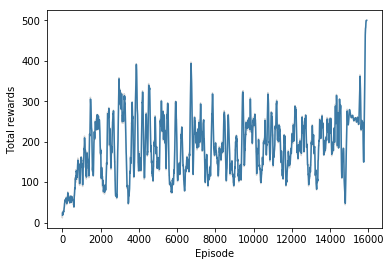

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

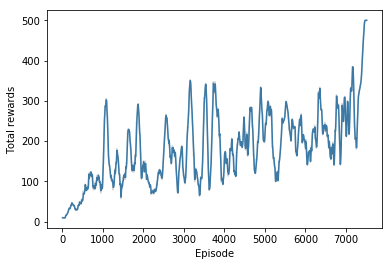

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

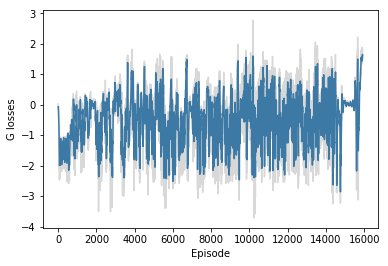

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

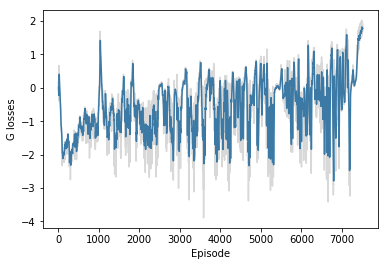

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

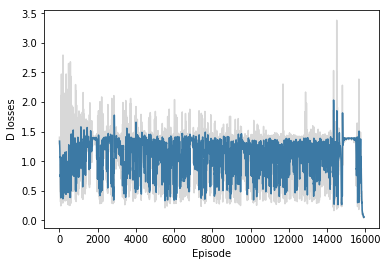

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

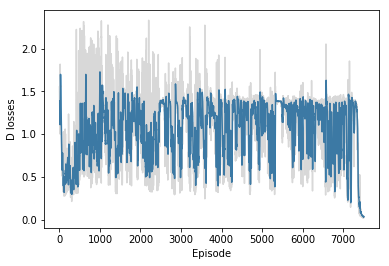

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

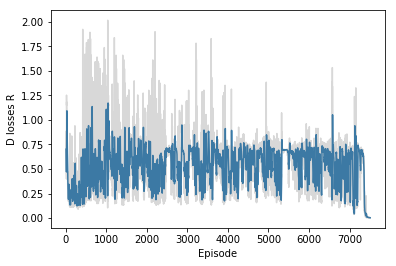

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

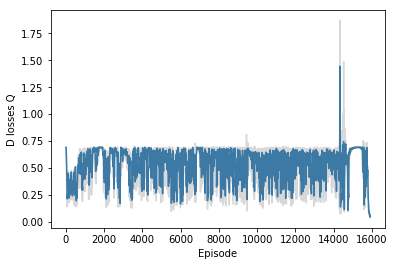

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

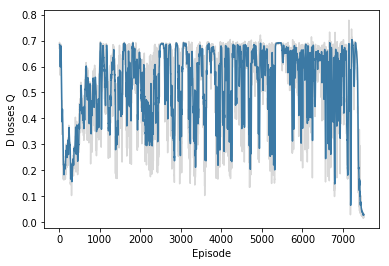

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.